# Figure 5 - Synchronized Cheese3D and electrophysiology recording analysis

This notebook contains the code to reproduce Fig5g-h.
To run this code, you need the following Anipose projects:
- `20240823_ephys-all_rig1_score_0_75`

Import video and ephys data

In [78]:
import os
import re
import gc
import cv2
import json
import numpy as np
import seaborn as sns
from moviepy.editor import VideoFileClip
import random
import pandas as pd
from kilosort.io import BinaryRWFile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from fepipeline.features.landmarks import read_3d_data
from fepipeline.anatomy import compute_anatomical_measurements, compute_measurements_df
from labutils.plotting import (sns_setup,
                               landmark_cmap,
                               measurements_cmap,
                               save_figure)
from pathlib import Path
import labutils.allego_fr as afr
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from functools import reduce
from scipy import signal
from itertools import islice, chain

sns_setup(font="Arial")

SESSION_INDEX = 'R28_0918_0'
SPIKE_DIR = "/home/lz/repos/mouse-fe-analysis/ephys-data/20240918_R28_ephys-record_rig1"
SPIKE_TIMES = os.path.join(SPIKE_DIR, "spike-time_good")
RAW_SPIKE_TIMES = os.path.join(SPIKE_DIR, "raw_spike-times/")
EPHYS_DIR = os.path.join(SPIKE_DIR, "ephys/")
CLUSTER_INFO = os.path.join(EPHYS_DIR, "cluster_info.tsv")
RAW_BINFILE = os.path.join(EPHYS_DIR, "R28_0918_0.bin")
TEMPLATES = os.path.join(EPHYS_DIR, "templates.npy")
ALIGNER = os.path.join(SPIKE_DIR, "R28_0__uid0918-12-03-41.align.json")
CHAN_MAP = os.path.join(EPHYS_DIR, "channel_map.npy")

GEOMETRIC_DIR = "/home/lz/repos/mouse-fe-analysis/anipose-projects/20240823_ephys-all_rig1_score_0_75/20240918_R28_ephys-record_awake_000_12-03-36"
GEOMETRIC_DATA = os.path.join(GEOMETRIC_DIR, "pose-3d/20240918_R28_ephys-record_awake_000_12-03-36.csv")
GEOMETRIC_VID = os.path.join(GEOMETRIC_DIR, "videos-compare/20240918_R28_ephys-record_awake_000_12-03-36.mp4")
GEOMETRIC_VID2 = os.path.join(GEOMETRIC_DIR,"videos-2d-proj/20240918_R28_ephys-record_awake_000_12-03-36.mp4")
ALIGN_VID = os.path.join(GEOMETRIC_DIR, "videos-raw/20240918_R28_ephys-record_awake_000_12-03-36.avi")
POSE_3D = pd.read_csv(GEOMETRIC_DATA, header=0)

OUTPUT_DIR = "/home/lz/repos/mouse-fe-analysis/figures/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
_, LANDMARK_CMAP = landmark_cmap()
_, MEASUREMENT_CMAP = measurements_cmap()
CRANIOTOMY_MAP = {
    "R20": "right",
    "R22": "left",
    "R28": "right"
}

# Crop any data outside the first 10 min
start_time = 0
end_time = 600

# ephys and video alignment
aligner_info = open(ALIGNER)
aligner_info = json.load(aligner_info)
frame_rate = 100
sample_rate = aligner_info['sample_rate']
lag_time = aligner_info['lag_time']

Import spike sorting data

In [79]:
templates = np.load(TEMPLATES)
cluster_info = pd.read_csv(CLUSTER_INFO, sep='\t', header=0)
chan_map = np.load(CHAN_MAP)
n_channels = len(chan_map.flatten())
binfile = BinaryRWFile(filename=RAW_BINFILE, n_chan_bin=n_channels)
raw_spike_time = {}
raw_spike_file_names = [file for file in os.listdir(RAW_SPIKE_TIMES) if file.endswith('.npy')]
for name in raw_spike_file_names:
    raw_spike_file_path = os.path.join(RAW_SPIKE_TIMES,name)
    raw_spike_time[name] = np.load(raw_spike_file_path)
raw_spike_time.keys()

dict_keys(['cluster68_raw.npy', 'cluster21_raw.npy', 'cluster45_raw.npy', 'cluster32_raw.npy', 'cluster14_raw.npy', 'cluster8_raw.npy', 'cluster48_raw.npy', 'cluster34_raw.npy', 'cluster20_raw.npy', 'cluster26_raw.npy', 'cluster39_raw.npy', 'cluster62_raw.npy', 'cluster43_raw.npy', 'cluster7_raw.npy'])

Plot spike waveforms for all units in the session (Figure. 5G shows example units 14 and 7)

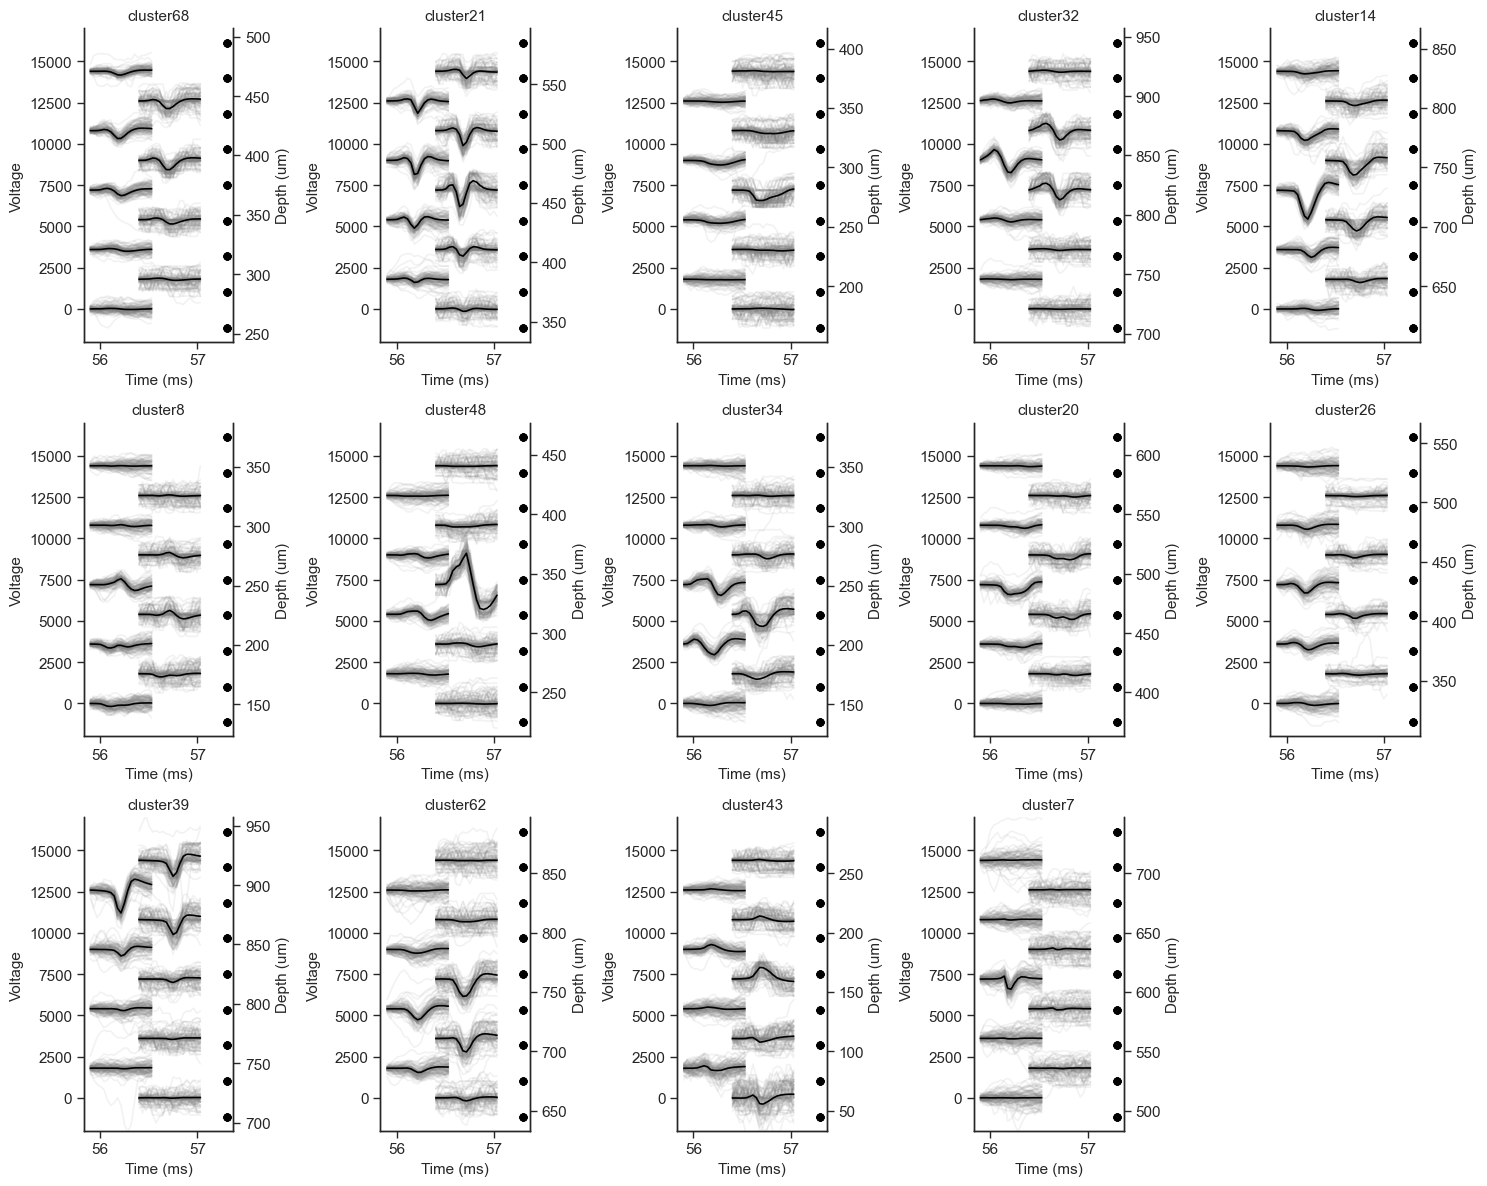

In [80]:
# Specify the channel depths according to channel map
left_channels = [15, 11, 7, 5, 1, 2, 4, 8, 10, 6, 0, 3, 12, 13, 9, 14]
right_channels = [16, 20, 21, 24, 26, 28, 27, 29, 31, 30, 25, 23, 19, 18, 22, 17]
left_depth = 15 + 60 * np.arange(0,16)[::-1]
right_depth = 45 + 60 * np.arange(0,16)[::-1]
raw_spike_time_keys = raw_spike_time.keys()
cluster_ids = [int(key.split('cluster')[1].split('_')[0]) for key in raw_spike_time_keys]
fig, axes = plt.subplots(len(cluster_ids)//5+1, 5, figsize=(15, 4 * (len(cluster_ids)//5+1)))
axes = axes.flatten()
for m, cluster_id in enumerate(cluster_ids):
    cluster_name = f'cluster{cluster_id}_raw.npy'
    ch_id = cluster_info.loc[cluster_info['cluster_id'] == cluster_id, 'ch'].values
    if len(ch_id) == 0:
        print(f"No channel info for cluster_id {cluster_id}")
        continue
    ch_id = ch_id[0]
    if ch_id in left_channels:
        ch_idx = left_channels.index(ch_id)
        if 2 <= ch_idx <= 13:
            channels = [
                left_channels[ch_idx - 2], right_channels[ch_idx - 1],
                left_channels[ch_idx - 1], right_channels[ch_idx],
                left_channels[ch_idx], right_channels[ch_idx + 1],
                left_channels[ch_idx + 1], right_channels[ch_idx + 2],
                left_channels[ch_idx + 2]
            ]
            depth = [
                left_depth[ch_idx - 2], right_depth[ch_idx - 1],
                left_depth[ch_idx - 1], right_depth[ch_idx],
                left_depth[ch_idx], right_depth[ch_idx + 1],
                left_depth[ch_idx + 1], right_depth[ch_idx + 2],
                left_depth[ch_idx + 2]
            ]
        elif ch_idx < 2:
            channels = [
                right_channels[0], left_channels[0], right_channels[1], left_channels[1],
                right_channels[2], left_channels[2], right_channels[3], left_channels[3],
                right_channels[4]
            ]
            depth = [
                right_depth[0], left_depth[0], right_depth[1], left_depth[1],
                right_depth[2], left_depth[2], right_depth[3], left_depth[3],
                right_depth[4]
            ]
        elif ch_idx > 13:
            channels = [
                right_channels[:-1], left_channels[:-1], right_channels[:-2], left_channels[:-2],
                right_channels[:-3], left_channels[:-3], right_channels[:-4], left_channels[:-4],
                right_channels[:-5]
            ]
            depth = [
                right_depth[:-1], left_depth[:-1], right_depth[:-2], left_depth[:-2],
                right_depth[:-3], left_depth[:-3], right_depth[:-4], left_depth[:-4],
                right_depth[:-5]
            ]
    if ch_id in right_channels:
        ch_idx = right_channels.index(ch_id)
        if 2 <= ch_idx <= 13:
            channels = [
                right_channels[ch_idx - 2], left_channels[ch_idx - 2],
                right_channels[ch_idx - 1], left_channels[ch_idx - 1],
                right_channels[ch_idx], left_channels[ch_idx],
                right_channels[ch_idx + 1], left_channels[ch_idx + 1],
                right_channels[ch_idx + 2]
            ]
            depth=[
                right_depth[ch_idx - 2], left_depth[ch_idx - 2],
                right_depth[ch_idx - 1], left_depth[ch_idx - 1],
                right_depth[ch_idx], left_depth[ch_idx],
                right_depth[ch_idx + 1], left_depth[ch_idx + 1],
                right_depth[ch_idx + 2]
            ]
        elif ch_idx < 2:
            channels = [
                left_channels[0], right_channels[0], left_channels[1], right_channels[1],
                left_channels[2], right_channels[2], left_channels[3], right_channels[3],
                left_channels[4]
            ]
            depth = [
                left_depth[0], right_depth[0], left_depth[1], right_depth[1],
                left_depth[2], right_depth[2], left_depth[3], right_depth[3],
                left_depth[4]
            ]
        elif ch_idx > 13:
            channels = [
                left_channels[:-1], right_channels[:-1], left_channels[:-2], right_channels[:-2],
                left_channels[:-3], right_channels[:-3], left_channels[:-4], right_channels[:-4],
                left_channels[:-5]
            ]
            depth = [
                left_depth[:-1], right_depth[:-1], left_depth[:-2], right_depth[:-2],
                left_depth[:-3], right_depth[:-3], left_depth[:-4], right_depth[:-4],
                left_depth[:-5]
            ]
    ax1 = axes[m]
    ax2 = ax1.twinx()
    for j, channel in enumerate(channels[::-1]):
        voltage_trace = binfile[:, channel].astype(int)
        spike_indices = raw_spike_time[cluster_name].astype(int)
        start_index = -10
        end_index = 10
        time_start = start_index/sample_rate + lag_time
        time_end = end_index/sample_rate + lag_time
        time_array = np.linspace(time_start, time_end, num = end_index - start_index) * 1000
        cluster_voltage = np.zeros((len(spike_indices), end_index-start_index))
        for i, time in enumerate(spike_indices):
            if time[0] + start_index >= 0 and time[0] + end_index <= len(voltage_trace):
                cluster_voltage[i, :] = voltage_trace[time[0] + start_index:time[0] + end_index]
            else:
                print(f"Skipping index {i}: out of bounds (time: {time[0]}).")
        
        # bring each individual trace to a similar baseline; 
        # use the avg of the first 3 datapoints as a baseline
        duration = 1
        pre_spike_voltage = np.zeros((len(spike_indices), duration))
        for i, time in enumerate(spike_indices):
            if time[0] + start_index >= 0 and time[0] + end_index <= len(voltage_trace):
                pre_spike_voltage[i, :] = voltage_trace[time[0] + start_index:time[0] + start_index + duration]
            else:
                print(f"Skipping index {i}: out of bounds (time: {time[0]}).")
        baseline = np.mean(pre_spike_voltage, axis = 1)

        average_trace = np.mean(cluster_voltage.T, axis=1)
        adjusted_cluster_voltage = np.zeros((len(spike_indices), end_index-start_index))
        for k in np.arange(len(baseline)):
            adjusted_cluster_voltage[k, :] = cluster_voltage[k, :] - baseline[k]
        adjusted_average_trace = average_trace - np.mean(baseline)

        # plot 100 random waveform traces and their mean
        num_traces = 100
        if len(adjusted_cluster_voltage) >= num_traces:
            selected_indices = np.random.choice(adjusted_cluster_voltage.shape[0], num_traces, replace=False)
            selected_traces = adjusted_cluster_voltage.T[:, selected_indices]
        else:
            print(f"Not enough traces to select {num_traces}. Selecting all available traces.")
            selected_traces = adjusted_cluster_voltage.T

        if channel in left_channels:
            ax1.plot(time_array[duration:], selected_traces[duration:] + 1800 * j, color = 'gray', alpha = 0.1)
            ax1.plot(time_array[duration:], adjusted_average_trace[duration:] + 1800 * j, color = 'black')    
        else:
            ax1.plot(time_array[duration:] + 0.5, selected_traces[duration:] + 1800 * j, color = 'gray', alpha = 0.1)
            ax1.plot(time_array[duration:] + 0.5, adjusted_average_trace[duration:] + 1800 * j, color = 'black')
        # plot the locations of recording sites with a black dot
        ax2.plot([57.3] * len(depth), depth, marker='o', linestyle='', color='k', alpha=0.6)     
        ax1.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax1.set_xlabel("Time (ms)")
        ax1.set_ylabel("Voltage")
        ax2.set_ylabel("Depth (um)")
        ax1.set_ylim([-2000,17000])
        ax1.set_title(f"{cluster_name[:-8]}")
for m in range(len(cluster_ids), len(axes)):
    fig.delaxes(axes[m])
plt.tight_layout()
plt.show()     

Extract facial landmarks time-series data  

In [81]:
landmarks = read_3d_data(GEOMETRIC_DIR)
parts = compute_anatomical_measurements(landmarks)
mea_data = {}
for part, measurements in parts.items():
    for measure_name, measure_data in measurements.items():
        measure_parts = measure_name.split('(')[0].strip().lower().split(' ')
        measure_part = '-'.join(measure_parts)
        key = f"{part}-{measure_part}"
        if '(L)' in measure_name:
            key += '-left'
        elif '(R)' in measure_name:
            key += '-right'
        mea_data[key] = measure_data
mea_df = pd.DataFrame(mea_data) 

# disgard the first video frame to match the number of spike bins
# therefore, for future plots, the start_time for video is start_time + time_window
mea_df = mea_df.iloc[start_time*frame_rate+1: end_time*frame_rate,:]
mea_df.head()

,eye-eye-height-left,eye-eye-height-right,eye-eye-width-left,eye-eye-width-right,eye-eye-area-left,eye-eye-area-right,ear-ear-height-left,ear-ear-height-right,ear-ear-width-left,ear-ear-width-right,ear-ear-angle-left,ear-ear-angle-right,ear-ear-area-left,ear-ear-area-right,mouth-mouth-area,nose-nose-bulge-volume,cheek-cheek-bulge-volume
1,2.368148,2.400640,3.523457,3.364178,6.599927,6.489455,10.074652,11.128053,7.234043,7.052618,164.635595,158.857918,62.263222,71.157333,3.072299,9.504149,38.210363
2,2.365989,2.406620,3.526024,3.364442,6.600860,6.505075,10.104143,11.130601,7.244226,7.095705,164.780343,158.869725,62.463994,71.309727,3.033070,9.564214,37.843604
3,2.364102,2.413162,3.527608,3.364533,6.600125,6.523096,10.127523,11.131421,7.246532,7.124382,164.874100,158.840530,62.597654,71.416311,3.006422,9.601932,37.500646
4,2.362603,2.420178,3.528193,3.364453,6.598001,6.543154,10.144918,11.130885,7.241857,7.138688,164.922129,158.772367,62.665876,71.468108,2.989915,9.619832,37.185743
5,2.361638,2.427511,3.527766,3.364130,6.594898,6.564456,10.156494,11.129533,7.232105,7.138802,164.931757,158.670269,62.677261,71.460275,2.979717,9.622049,36.907818


Plot unprocessed facial features 

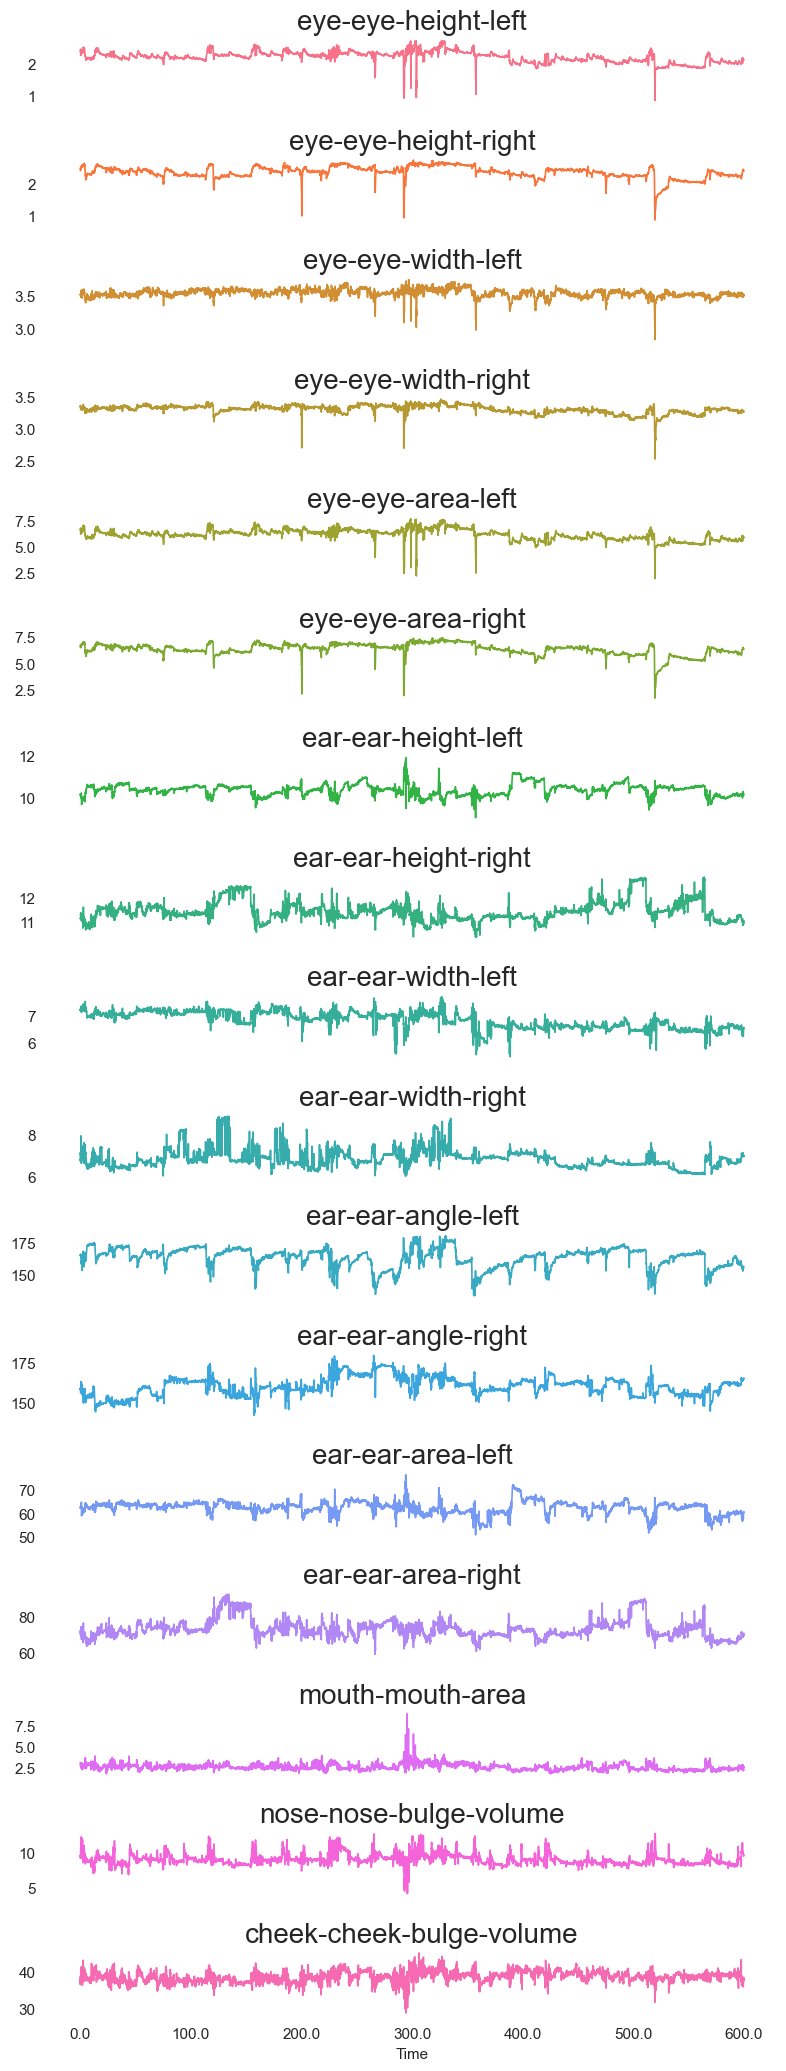

In [82]:
# Facial movement (unnormalized)
def plot_trace(data, color, label):
    sns.lineplot(x=np.arange(len(data)), y=data,
                 color=color,
                 label=label)
    
mea_df_melted = mea_df.melt(var_name='measurement', value_name='timeseries')
# selected_mea_df_melted = pd.concat([mea_df.iloc[:,0:6], mea_df.iloc[:,7], mea_df.iloc[:,9], mea_df.iloc[:,11], mea_df.iloc[:,13]], axis=1).melt(var_name='measurement', value_name='timeseries')

# g = sns.FacetGrid(selected_mea_df_melted,
g = sns.FacetGrid(mea_df_melted,
                  col="measurement", hue="measurement",
                  col_wrap=1, aspect=8, height=1,
                  margin_titles=False, sharey=False)

g.map(plot_trace, "timeseries")

g.set_xlabels("Time")
g.tick_params(left = False, bottom=False)
# g.set_xticklabels("")
# g.set_yticklabels("")
# g.set_xlabels("")
g.set_ylabels("")
g.set_titles(col_template="{col_name}")
# g.set_titles("")
g.tight_layout()
g.fig.subplots_adjust(top=1.2)

for ax in g.axes.flat:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.tick_params(axis="both", which="both", bottom=False, left=False)
    ax.set_xticklabels(ax.get_xticks() / 100)
    ax.set_title(ax.get_title(), fontsize=20)

Find timestamps for outliers in DeepLabCut labeling with a low confidence score

Text(0.5, 92.89945005677991, 'Indices (/100 = time in sec)')

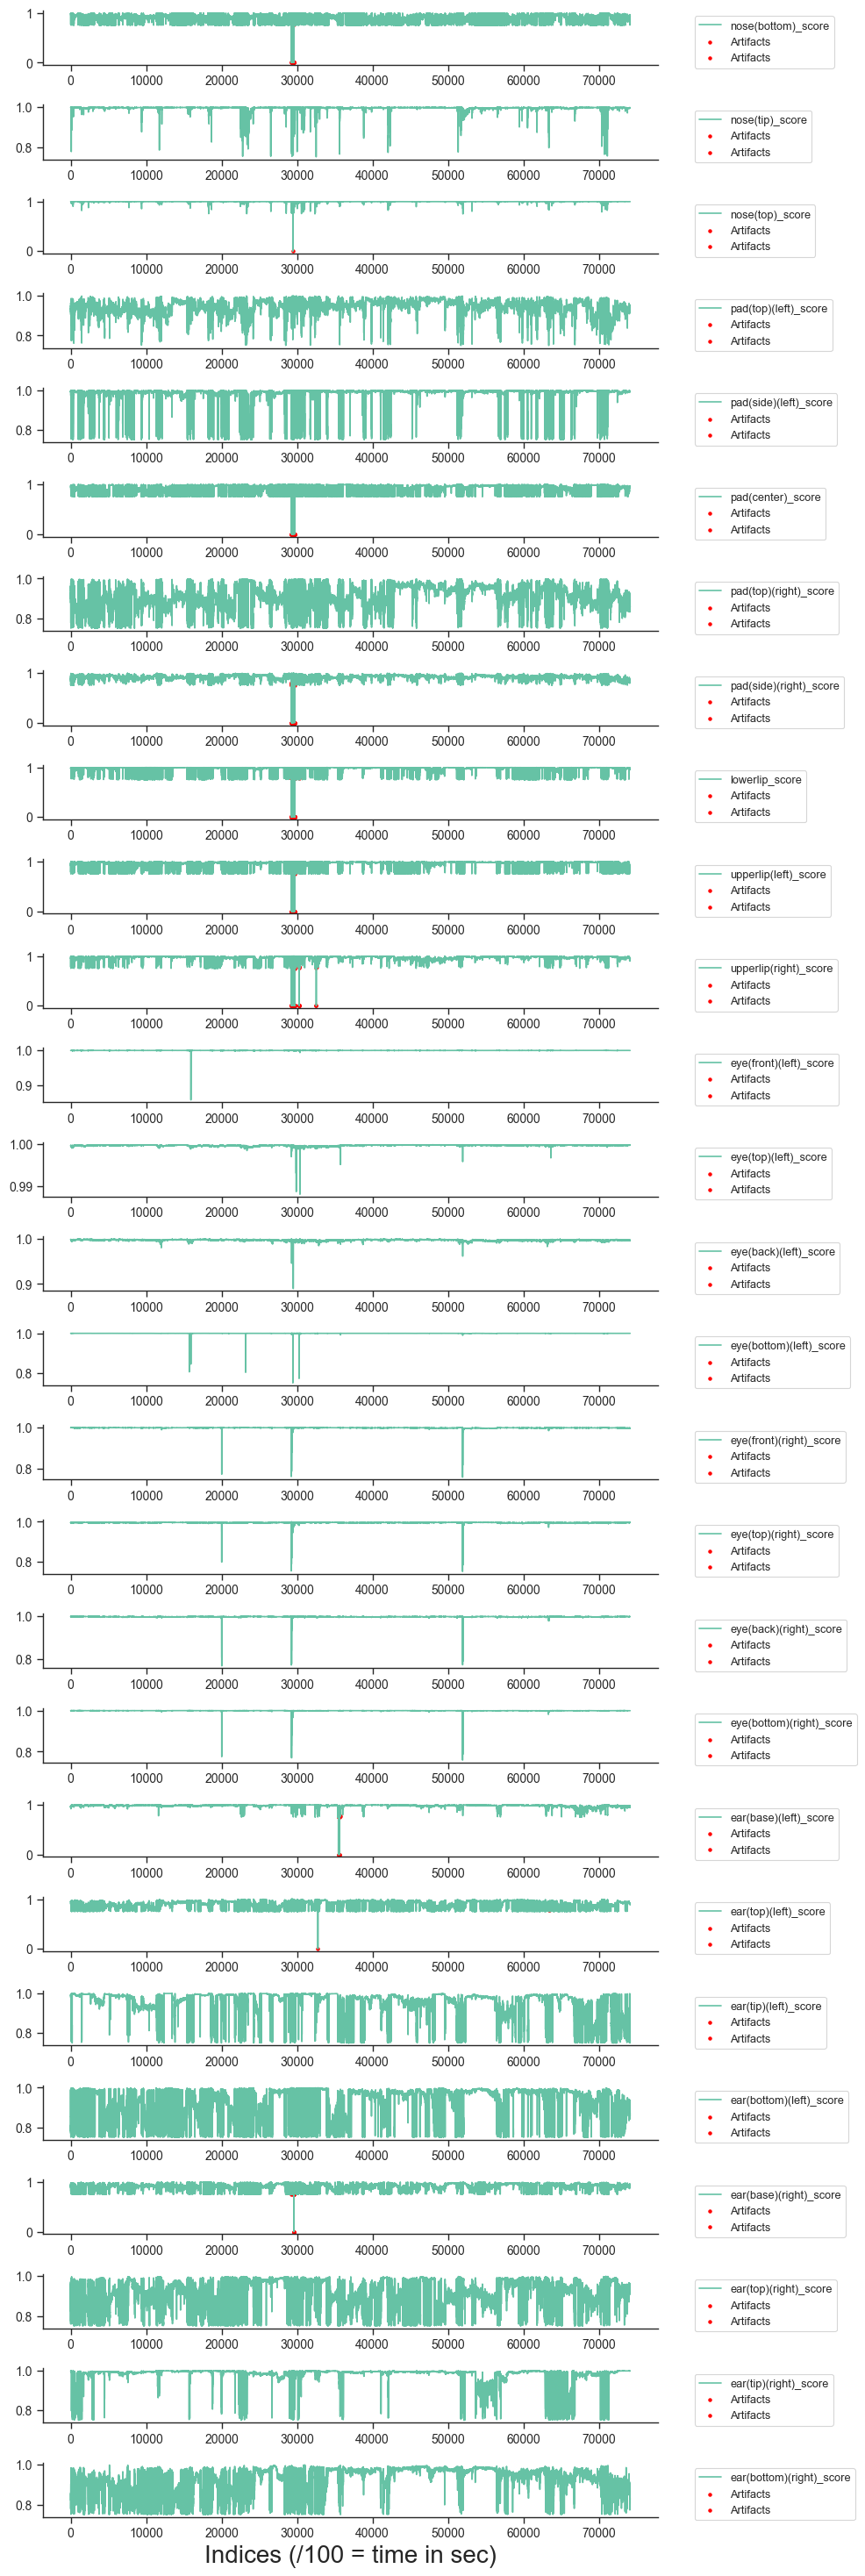

In [83]:
score_columns = POSE_3D.columns[POSE_3D.columns.str.contains('score')]
ncams_columns = POSE_3D.columns[POSE_3D.columns.str.contains('ncams')]
i = 0
artifacts = {}
plt.figure(figsize=(10, 30))
for col in score_columns:    
    spikes = np.isnan(POSE_3D[col])
    low_confidences = (POSE_3D[ncams_columns[i]] <= 1) & (POSE_3D[score_columns[i]] < 0.8)
    low_confidences = np.array(low_confidences[low_confidences].index)
    artifacts[col[:-6]] = np.union1d(np.where(spikes), low_confidences)
    ax = plt.subplot(len(score_columns), 1, i+1)
    plt.plot(np.nan_to_num(POSE_3D[col], nan=0), label = col)
    plt.scatter(np.where(spikes), np.nan_to_num(POSE_3D[col][spikes], nan=0), marker='.', color='red', label='Artifacts')
    plt.scatter(low_confidences, POSE_3D[col][low_confidences], marker='.', color='red', label='Artifacts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    i = i + 1
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')  
    plt.tight_layout()
    if i >= len(score_columns)-1:    # disgard the last score column (ref(head_post)_score)
        break
plt.xlabel('Indices (/100 = time in sec)',fontsize=20)

In [84]:
eye_height_left_artifacts = np.union1d(artifacts['eye(top)(left)'], artifacts['eye(bottom)(left)'])
eye_height_right_artifacts = np.union1d(artifacts['eye(top)(right)'], artifacts['eye(bottom)(right)'])
eye_width_left_artifacts = np.union1d(artifacts['eye(front)(left)'], artifacts['eye(back)(left)'])
eye_width_right_artifacts = np.union1d(artifacts['eye(front)(right)'], artifacts['eye(back)(right)'])
eye_area_left_artifacts = reduce(np.union1d, (artifacts['eye(top)(left)'], artifacts['eye(bottom)(left)'], artifacts['eye(front)(left)'], artifacts['eye(back)(left)']))
eye_area_right_artifacts = reduce(np.union1d, (artifacts['eye(top)(right)'], artifacts['eye(bottom)(right)'], artifacts['eye(front)(right)'], artifacts['eye(back)(right)']))

ear_height_left_artifacts = np.union1d(artifacts['ear(base)(left)'], artifacts['ear(tip)(left)'])
ear_height_right_artifacts = np.union1d(artifacts['ear(base)(right)'], artifacts['ear(tip)(right)'])
ear_width_left_artifacts = np.union1d(artifacts['ear(top)(left)'], artifacts['ear(bottom)(left)'])
ear_width_right_artifacts = np.union1d(artifacts['ear(top)(right)'], artifacts['ear(bottom)(right)'])
ear_angle_left_artifacts = reduce(np.union1d, (artifacts['ear(tip)(left)'], artifacts['ear(base)(left)'], artifacts['pad(center)']))
ear_angle_right_artifacts = reduce(np.union1d, (artifacts['ear(tip)(right)'], artifacts['ear(base)(right)'], artifacts['pad(center)']))
ear_area_left_artifacts = reduce(np.union1d, (artifacts['ear(base)(left)'], artifacts['ear(tip)(left)'], artifacts['ear(top)(left)'], artifacts['ear(bottom)(left)']))
ear_area_right_artifacts = reduce(np.union1d, (artifacts['ear(base)(right)'], artifacts['ear(tip)(right)'], artifacts['ear(top)(right)'], artifacts['ear(bottom)(right)']))

mouth_area_artifacts = reduce(np.union1d, (artifacts['lowerlip'], artifacts['upperlip(left)'], artifacts['upperlip(right)']))
nose_bulge_volume_artifacts = reduce(np.union1d, (artifacts['eye(front)(left)'], artifacts['eye(front)(right)'], artifacts['nose(top)'], artifacts['pad(top)(left)'], artifacts['pad(top)(right)']))
cheek_bulge_volume_artifacts = reduce(np.union1d, (artifacts['nose(bottom)'], artifacts['pad(top)(left)'], artifacts['pad(top)(right)'], artifacts['pad(side)(left)'], artifacts['pad(side)(right)']))

facial_feature_artifacts = [eye_height_left_artifacts, eye_height_right_artifacts, eye_width_left_artifacts, eye_width_right_artifacts,
                            eye_area_left_artifacts, eye_area_right_artifacts, ear_height_left_artifacts, ear_height_right_artifacts, 
                            ear_width_left_artifacts, ear_width_right_artifacts, ear_angle_left_artifacts, ear_angle_right_artifacts,
                            ear_area_left_artifacts, ear_area_right_artifacts, mouth_area_artifacts, nose_bulge_volume_artifacts,
                            cheek_bulge_volume_artifacts]

In [85]:
spike_time = {}
spike_file_names = [file for file in os.listdir(SPIKE_TIMES) if file.endswith('.npy')]
for name in spike_file_names:
    spike_file_path = os.path.join(SPIKE_TIMES,name)
    spike_time[name] = np.load(spike_file_path)
spike_time.keys()

dict_keys(['cluster62.npy', 'cluster14.npy', 'cluster39.npy', 'cluster8.npy', 'cluster32.npy', 'cluster43.npy', 'cluster68.npy', 'cluster20.npy', 'cluster48.npy', 'cluster7.npy', 'cluster21.npy', 'cluster26.npy', 'cluster45.npy', 'cluster34.npy'])

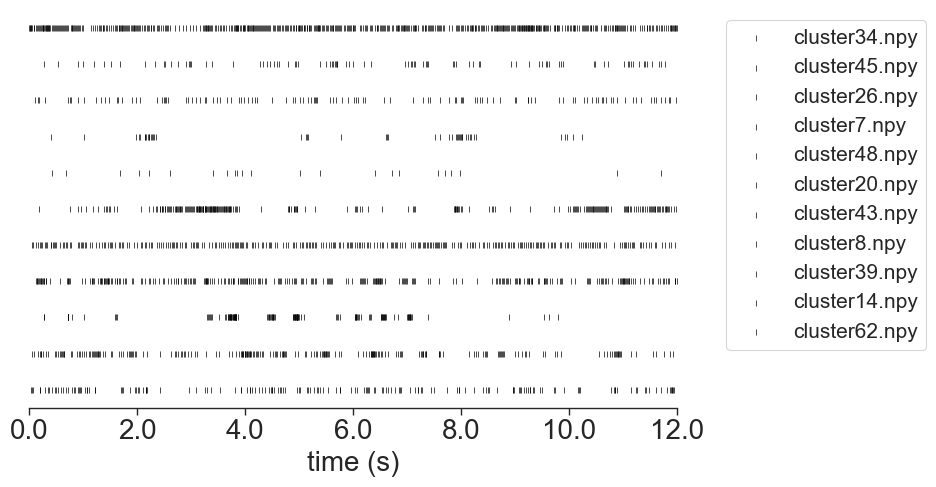

In [86]:
plt.figure(figsize=(10, 5))
# bad_unit = 'cluster68.npy'
# filtered_spike_file_names = [name for name in spike_file_names if bad_unit not in name]
bad_units = ['68', '21', '32'] # noise; high fr; high fr
filtered_spike_file_names = [name for name in spike_file_names if not any(bad_unit in name for bad_unit in bad_units)]
offsets = np.arange(len(filtered_spike_file_names))
for i, name in enumerate(filtered_spike_file_names):
    plt.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
                marker='|', label = f'{name}', linewidths=0.5, color = 'k')

plt.xticks(fontsize=15)
plt.xlabel('time (s)', fontsize=20)
plt.yticks([])
plt.xlim([298,310])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(1.4,1), fontsize=15)
ax = plt.gca()
ax.set_xticklabels(np.linspace(0, 12, 7) , fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
# plt.savefig(f"{SESSION_INDEX}_raster_plot.svg", format = "svg", dpi=300)
plt.show() 

In [87]:
# Firing rate (unnormalized)
def calculate_firing_rate(spike_times_dict, time_window, start_time, end_time):
    firing_rates = {cluster_id: [] for cluster_id in spike_times_dict.keys()}
    
    for cluster_id, spike_times in spike_times_dict.items():
        n, _ = np.histogram(spike_times, bins=np.arange(start_time, end_time, time_window))
        firing_rates[cluster_id].append(n/time_window)

    return firing_rates
   
time_window = 0.01 
fr = calculate_firing_rate(spike_time, time_window, start_time, end_time)
# len(fr['cluster2.npy'][0])

In [88]:
spikeQC = pd.read_csv('/home/lz/repos/mouse-fe-analysis/Cheese3D + electrophysiology new data - Ephys recording units.csv')
session_QC_df = spikeQC[spikeQC['Session'] == SESSION_INDEX]
sorted_session_QC_df = session_QC_df.sort_values(by = 'Depth')
spike_names=sorted_session_QC_df['Name'].astype('str').tolist()
for i, name in enumerate(spike_names):
    name = name[11:] + '.npy'
    spike_names[i] = name

Figure 5G example section of facial data and raster plot

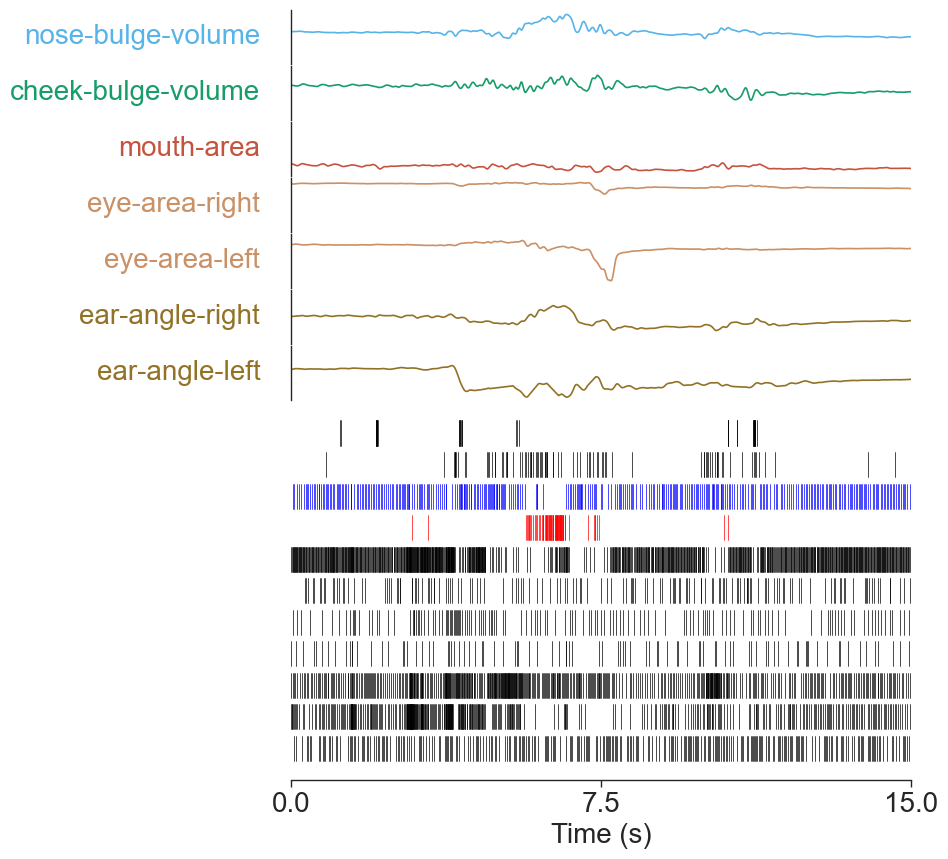

In [89]:
start_time = 350
end_time = 365

# Create a subset dictionary with spike times between start_time to end_time
spike_time_subset = {
    name: times[(times >= start_time) & (times <= end_time)]
    for name, times in spike_time.items()
    }
# print(spike_time_subset['cluster7.npy'])

# Replace the artifacts with NaN, then interpolate the missing values
def categorize_features(feature):
    if "eye-eye-height-left" in feature or "eye-eye-width-left" in feature or "eye-eye-area-left" in feature:
        return 0
    elif "eye-eye-height-right" in feature or "eye-eye-width-right" in feature or "eye-eye-area-right" in feature:
        return 1
    elif "ear-ear-height-left" in feature or "ear-ear-width-left" in feature or "ear-ear-angle-left" in feature or "ear-ear-area-left" in feature:
        return 2
    elif "ear-ear-height-right" in feature or "ear-ear-width-right" in feature or "ear-ear-angle-right" in feature or "ear-ear-area-right" in feature:
        return 3
    elif "mouth-mouth-area" in feature:
        return 4
    elif "nose-nose-bulge-volume" in feature:
        return 5
    else:
        return 6
sorted_features = sorted(mea_df.columns, key=categorize_features)

selected_features = ["nose-nose-bulge-volume", "cheek-cheek-bulge-volume", "mouth-mouth-area",
                     "eye-eye-area-right", "eye-eye-area-left", "ear-ear-angle-right", "ear-ear-angle-left"]         
clean_mea_df = pd.DataFrame()
# fig = plt.figure(figsize=(8, 25))
fig = plt.figure(figsize=(8, 10))
# fig = plt.figure(figsize=(4, 10))
# gs = GridSpec(len(sorted_features) + 1, 1, height_ratios=[1] * len(sorted_features) + [5], hspace=0.05)
gs = GridSpec(len(selected_features) + 1, 1, height_ratios=[1] * len(selected_features) + [7], hspace=0.02)

i = 0      

# for feature in sorted_features: # to be commented if only plotting 7 features
for feature in selected_features: 
    facial_data = mea_df[feature]
    # ax = fig.add_subplot(len(sorted_features), 1, i + 1) # to be commented if only plotting 7 features
    # ax1 = plt.subplot(len(sorted_features), 1, i + 1) # to be commented if only plotting 7 features
    ax1 = fig.add_subplot(gs[i])
    # plt.plot(np.arange(len(facial_data))/100, facial_data, label= facial_feature, color = colors[i])
    
    # Replace artifacts with NaN and interpolate
    clean_data = facial_data.copy()
    for j in np.arange(len(facial_feature_artifacts[i])):
        if len(facial_feature_artifacts[i]) > 0:
            artifact_range = facial_feature_artifacts[i][j]
            clean_data[(artifact_range - 10):(artifact_range + 10)] = np.nan
    x = np.arange(len(clean_data))
    valid_indices = ~np.isnan(clean_data)
    interpolated_value = np.interp(x, x[valid_indices], clean_data[valid_indices])
    clean_mea_df[feature] = interpolated_value

    # Plot the interpolated data
    label = feature
    cleaned_label = label.replace("-eye-", "-").replace("-ear-", "-").replace("-mouth-", "-").replace("-nose-", "-").replace("-cheek-", "-")
    color = MEASUREMENT_CMAP.get(cleaned_label, 'k')  # Default to black if color not found
    plt.plot(np.arange(len(facial_data)) / 100, clean_mea_df[feature], label=cleaned_label, color=color)

    # ax1.axvline(x=516.2, color='cyan', linestyle='--', linewidth=1)  # Vertical line at 513.5
    # ax1.axvline(x=520, color='orange', linestyle='--', linewidth=1) 
    ax1.text(-0.05, 0.5, cleaned_label, color=color, fontsize=20, 
             va='center', ha='right', transform=ax1.transAxes)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    plt.xlim([start_time, end_time])
    # plt.ylim([145,180])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax1.set_xticks([])
    ax1.set_yticks([])
    # plt.legend(loc='center left', bbox_to_anchor=(0, 1), fontsize=20)
    i += 1

# ax2 = fig.add_subplot(gs[17]) # raster plots; to be commented if only plotting 7 features
ax2 = fig.add_subplot(gs[7]) 
bad_units = ['68', '21', '32']
selected_units_1 = ['7'] # change it to cluster 7 if analyzing R28_0918
selected_spike_names_1 = [name for name in spike_names if any (selected_unit in name for selected_unit in selected_units_1)]
selected_units_2 = ['14'] # change it to cluster 14 if analyzing R28_0918
selected_spike_names_2 = [name for name in spike_names if any (selected_unit in name for selected_unit in selected_units_2)]
filtered_spike_names = [name for name in spike_names if not any(bad_unit in name for bad_unit in bad_units)]
offsets = np.arange(len(filtered_spike_names))
for i, name in enumerate(filtered_spike_names):
    if name in selected_spike_names_1:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'red')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='red', linewidth=0.5)
            ax2.add_line(line)
    elif name in selected_spike_names_2:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'blue')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='blue', linewidth=0.5)
            ax2.add_line(line)
    else:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'k')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='k', linewidth=0.5)
            ax2.add_line(line)
ax2.set_ylim([min(offsets) - 1, max(offsets) + 1])

    # ax2.axvline(x=516.2, color='cyan', linestyle='--', linewidth=1)  # Vertical line at 513.5
    # ax2.axvline(x=520, color='orange', linestyle='--', linewidth=1)
    
plt.xticks(fontsize=15)
plt.xlabel('Time (s)', fontsize=20)
plt.yticks([])
plt.xlim([start_time, end_time])
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(1.4,1), fontsize=15)
ax2 = plt.gca()
# tick_positions = np.linspace(509,524, 7)  # Set positions for ticks in the x-axis range
# tick_positions = np.linspace(350,365, 7)
tick_positions = np.linspace(start_time,end_time, 3)
# tick_labels = np.linspace(0, 15, 7)        # Set corresponding labels
tick_labels = np.linspace(0, end_time-start_time, 3) 
ax2.set_xticks(tick_positions)             # Define tick locations
ax2.set_xticklabels(tick_labels, fontsize=20)  # Assign labels to those locations
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()
# save_figure(OUTPUT_DIR, f"{SESSION_INDEX}_facial_features_section_{start_time}-{end_time}s", fig, formats=["svg","png"])
plt.show()


Figure 5H. example facial + raster plot sections 

The first section

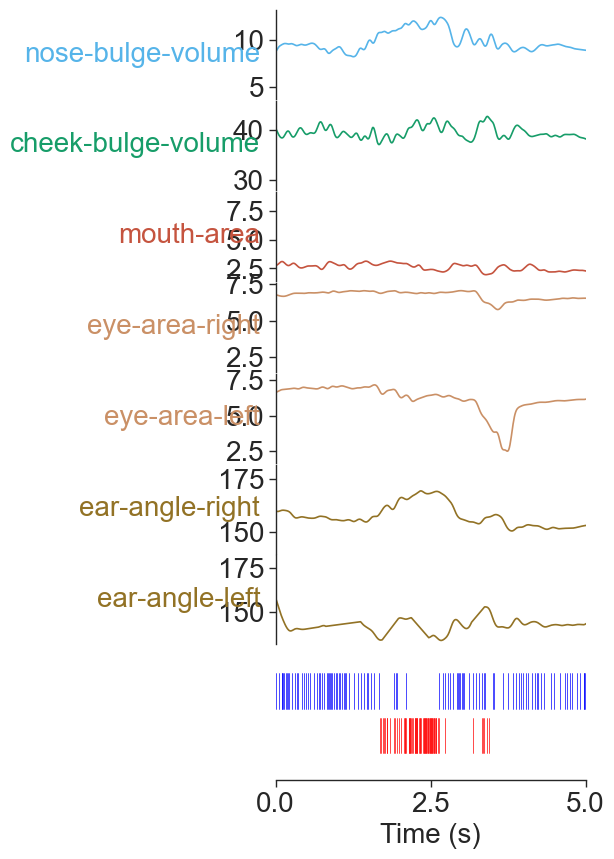

In [92]:
start_time = 354
end_time = 359

# Create a subset dictionary with spike times between start_time to end_time
spike_time_subset = {
    name: times[(times >= start_time) & (times <= end_time)]
    for name, times in spike_time.items()
    }

# Replace the artifacts with NaN, then interpolate the missing values
def categorize_features(feature):
    if "eye-eye-height-left" in feature or "eye-eye-width-left" in feature or "eye-eye-area-left" in feature:
        return 0
    elif "eye-eye-height-right" in feature or "eye-eye-width-right" in feature or "eye-eye-area-right" in feature:
        return 1
    elif "ear-ear-height-left" in feature or "ear-ear-width-left" in feature or "ear-ear-angle-left" in feature or "ear-ear-area-left" in feature:
        return 2
    elif "ear-ear-height-right" in feature or "ear-ear-width-right" in feature or "ear-ear-angle-right" in feature or "ear-ear-area-right" in feature:
        return 3
    elif "mouth-mouth-area" in feature:
        return 4
    elif "nose-nose-bulge-volume" in feature:
        return 5
    else:
        return 6
sorted_features = sorted(mea_df.columns, key=categorize_features)

selected_features = ["nose-nose-bulge-volume", "cheek-cheek-bulge-volume", "mouth-mouth-area",
                     "eye-eye-area-right", "eye-eye-area-left", "ear-ear-angle-right", "ear-ear-angle-left"]         
clean_mea_df = pd.DataFrame()
# fig = plt.figure(figsize=(8, 25))
# fig = plt.figure(figsize=(8, 10))
fig = plt.figure(figsize=(4, 10))
# gs = GridSpec(len(sorted_features) + 1, 1, height_ratios=[1] * len(sorted_features) + [5], hspace=0.05)
gs = GridSpec(len(selected_features) + 1, 1, height_ratios=[1] * len(selected_features) + [1.5], hspace=0.02)

i = 0      

# for feature in sorted_features: # to be commented if only plotting 7 features
for feature in selected_features: 
    facial_data = mea_df[feature]
    # ax = fig.add_subplot(len(sorted_features), 1, i + 1) # to be commented if only plotting 7 features
    # ax1 = plt.subplot(len(sorted_features), 1, i + 1) # to be commented if only plotting 7 features
    ax1 = fig.add_subplot(gs[i])
    # plt.plot(np.arange(len(facial_data))/100, facial_data, label= facial_feature, color = colors[i])
    
    # Replace artifacts with NaN and interpolate
    clean_data = facial_data.copy()
    for j in np.arange(len(facial_feature_artifacts[i])):
        if len(facial_feature_artifacts[i]) > 0:
            artifact_range = facial_feature_artifacts[i][j]
            clean_data[(artifact_range - 10):(artifact_range + 10)] = np.nan
    x = np.arange(len(clean_data))
    valid_indices = ~np.isnan(clean_data)
    interpolated_value = np.interp(x, x[valid_indices], clean_data[valid_indices])
    clean_mea_df[feature] = interpolated_value

    # Plot the interpolated data
    label = feature
    cleaned_label = label.replace("-eye-", "-").replace("-ear-", "-").replace("-mouth-", "-").replace("-nose-", "-").replace("-cheek-", "-")
    color = MEASUREMENT_CMAP.get(cleaned_label, 'k')  # Default to black if color not found
    plt.plot(np.arange(len(facial_data)) / 100, clean_mea_df[feature], label=cleaned_label, color=color)

    # ax1.axvline(x=516.2, color='cyan', linestyle='--', linewidth=1)  # Vertical line at 513.5
    # ax1.axvline(x=520, color='orange', linestyle='--', linewidth=1) 
    ax1.text(-0.05, 0.5, cleaned_label, color=color, fontsize=20, 
             va='center', ha='right', transform=ax1.transAxes)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    plt.xlim([start_time, end_time])
    # plt.ylim([145,180])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax1.set_xticks([])
    # ax1.set_yticks([])
    # plt.legend(loc='center left', bbox_to_anchor=(0, 1), fontsize=20)
    i += 1

# ax2 = fig.add_subplot(gs[17]) # raster plots; to be commented if only plotting 7 features
ax2 = fig.add_subplot(gs[7]) 
# bad_units = ['68', '21', '32']
bad_units = ['68', '21', '32', '8', '34', '20', '26', '39', '45', '48', '62', '43']
selected_units_1 = ['7'] # change it to cluster 7 if analyzing R28_0918
selected_spike_names_1 = [name for name in spike_names if any (selected_unit in name for selected_unit in selected_units_1)]
selected_units_2 = ['14'] # change it to cluster 14 if analyzing R28_0918
selected_spike_names_2 = [name for name in spike_names if any (selected_unit in name for selected_unit in selected_units_2)]
filtered_spike_names = [name for name in spike_names if not any(bad_unit in name for bad_unit in bad_units)]
offsets = np.arange(len(filtered_spike_names))
for i, name in enumerate(filtered_spike_names):
    if name in selected_spike_names_1:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'red')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='red', linewidth=0.5)
            ax2.add_line(line)
    elif name in selected_spike_names_2:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'blue')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='blue', linewidth=0.5)
            ax2.add_line(line)
    else:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'k')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='k', linewidth=0.5)
            ax2.add_line(line)
ax2.set_ylim([min(offsets) - 1, max(offsets) + 1])

    # ax2.axvline(x=516.2, color='cyan', linestyle='--', linewidth=1)  # Vertical line at 513.5
    # ax2.axvline(x=520, color='orange', linestyle='--', linewidth=1)
    
plt.xticks(fontsize=15)
plt.xlabel('Time (s)', fontsize=20)
plt.yticks([])
# plt.xlim([350,365])
# plt.xlim([509,524])
plt.xlim([start_time, end_time])
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(1.4,1), fontsize=15)
ax2 = plt.gca()
# tick_positions = np.linspace(509,524, 7)  # Set positions for ticks in the x-axis range
# tick_positions = np.linspace(350,365, 7)
tick_positions = np.linspace(start_time,end_time, 3)
# tick_labels = np.linspace(0, 15, 7)        # Set corresponding labels
tick_labels = np.linspace(0, end_time-start_time, 3) 
ax2.set_xticks(tick_positions)             # Define tick locations
ax2.set_xticklabels(tick_labels, fontsize=20)  # Assign labels to those locations
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()
# save_figure(OUTPUT_DIR, f"{SESSION_INDEX}_facial_features_section_{start_time}-{end_time}s", fig, formats=["svg","png"])
plt.show()


The second section

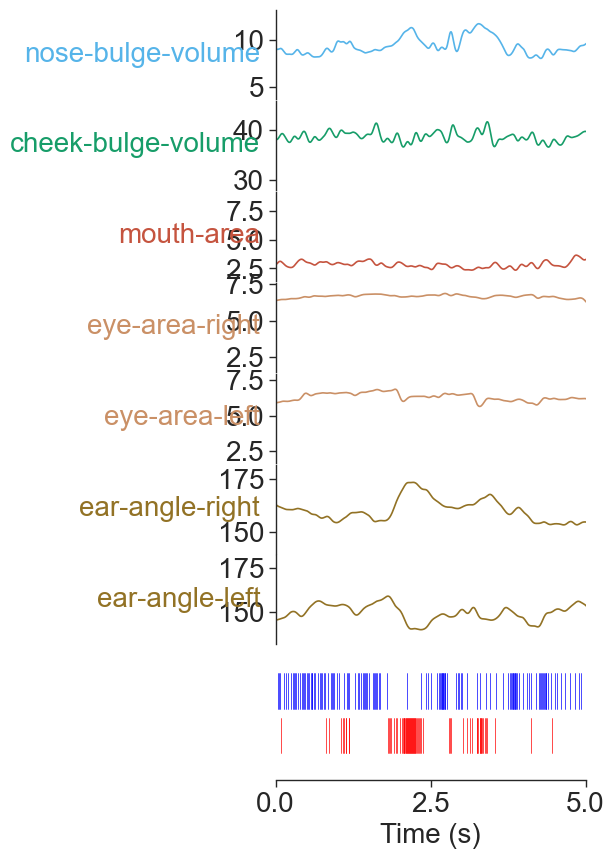

In [93]:
start_time = 514
end_time = 519

# Create a subset dictionary with spike times between start_time to end_time
spike_time_subset = {
    name: times[(times >= start_time) & (times <= end_time)]
    for name, times in spike_time.items()
    }

# Replace the artifacts with NaN, then interpolate the missing values
def categorize_features(feature):
    if "eye-eye-height-left" in feature or "eye-eye-width-left" in feature or "eye-eye-area-left" in feature:
        return 0
    elif "eye-eye-height-right" in feature or "eye-eye-width-right" in feature or "eye-eye-area-right" in feature:
        return 1
    elif "ear-ear-height-left" in feature or "ear-ear-width-left" in feature or "ear-ear-angle-left" in feature or "ear-ear-area-left" in feature:
        return 2
    elif "ear-ear-height-right" in feature or "ear-ear-width-right" in feature or "ear-ear-angle-right" in feature or "ear-ear-area-right" in feature:
        return 3
    elif "mouth-mouth-area" in feature:
        return 4
    elif "nose-nose-bulge-volume" in feature:
        return 5
    else:
        return 6
sorted_features = sorted(mea_df.columns, key=categorize_features)

selected_features = ["nose-nose-bulge-volume", "cheek-cheek-bulge-volume", "mouth-mouth-area",
                     "eye-eye-area-right", "eye-eye-area-left", "ear-ear-angle-right", "ear-ear-angle-left"]         
clean_mea_df = pd.DataFrame()
# fig = plt.figure(figsize=(8, 25))
# fig = plt.figure(figsize=(8, 10))
fig = plt.figure(figsize=(4, 10))
# gs = GridSpec(len(sorted_features) + 1, 1, height_ratios=[1] * len(sorted_features) + [5], hspace=0.05)
gs = GridSpec(len(selected_features) + 1, 1, height_ratios=[1] * len(selected_features) + [1.5], hspace=0.02)

i = 0      

# for feature in sorted_features: # to be commented if only plotting 7 features
for feature in selected_features: 
    facial_data = mea_df[feature]
    # ax = fig.add_subplot(len(sorted_features), 1, i + 1) # to be commented if only plotting 7 features
    # ax1 = plt.subplot(len(sorted_features), 1, i + 1) # to be commented if only plotting 7 features
    ax1 = fig.add_subplot(gs[i])
    # plt.plot(np.arange(len(facial_data))/100, facial_data, label= facial_feature, color = colors[i])
    
    # Replace artifacts with NaN and interpolate
    clean_data = facial_data.copy()
    for j in np.arange(len(facial_feature_artifacts[i])):
        if len(facial_feature_artifacts[i]) > 0:
            artifact_range = facial_feature_artifacts[i][j]
            clean_data[(artifact_range - 10):(artifact_range + 10)] = np.nan
    x = np.arange(len(clean_data))
    valid_indices = ~np.isnan(clean_data)
    interpolated_value = np.interp(x, x[valid_indices], clean_data[valid_indices])
    clean_mea_df[feature] = interpolated_value

    # Plot the interpolated data
    label = feature
    cleaned_label = label.replace("-eye-", "-").replace("-ear-", "-").replace("-mouth-", "-").replace("-nose-", "-").replace("-cheek-", "-")
    color = MEASUREMENT_CMAP.get(cleaned_label, 'k')  # Default to black if color not found
    plt.plot(np.arange(len(facial_data)) / 100, clean_mea_df[feature], label=cleaned_label, color=color)

    # ax1.axvline(x=516.2, color='cyan', linestyle='--', linewidth=1)  # Vertical line at 513.5
    # ax1.axvline(x=520, color='orange', linestyle='--', linewidth=1) 
    ax1.text(-0.05, 0.5, cleaned_label, color=color, fontsize=20, 
             va='center', ha='right', transform=ax1.transAxes)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    plt.xlim([start_time, end_time])
    # plt.ylim([145,180])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax1.set_xticks([])
    # ax1.set_yticks([])
    # plt.legend(loc='center left', bbox_to_anchor=(0, 1), fontsize=20)
    i += 1

# ax2 = fig.add_subplot(gs[17]) # raster plots; to be commented if only plotting 7 features
ax2 = fig.add_subplot(gs[7]) 
# bad_units = ['68', '21', '32']
bad_units = ['68', '21', '32', '8', '34', '20', '26', '39', '45', '48', '62', '43']
selected_units_1 = ['7'] # change it to cluster 7 if analyzing R28_0918
selected_spike_names_1 = [name for name in spike_names if any (selected_unit in name for selected_unit in selected_units_1)]
selected_units_2 = ['14'] # change it to cluster 14 if analyzing R28_0918
selected_spike_names_2 = [name for name in spike_names if any (selected_unit in name for selected_unit in selected_units_2)]
filtered_spike_names = [name for name in spike_names if not any(bad_unit in name for bad_unit in bad_units)]
offsets = np.arange(len(filtered_spike_names))
for i, name in enumerate(filtered_spike_names):
    if name in selected_spike_names_1:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'red')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='red', linewidth=0.5)
            ax2.add_line(line)
    elif name in selected_spike_names_2:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'blue')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='blue', linewidth=0.5)
            ax2.add_line(line)
    else:
        # ax2.scatter(spike_time[name], offsets[i]* np.ones_like((spike_time[name])), 
        #         marker='|', label = f'{name}', linewidths=0.5, color = 'k')
        for spike in spike_time_subset[name]:
            line = Line2D([spike, spike], [offsets[i] - 0.4, offsets[i] + 0.4], 
                          color='k', linewidth=0.5)
            ax2.add_line(line)
ax2.set_ylim([min(offsets) - 1, max(offsets) + 1])

    # ax2.axvline(x=516.2, color='cyan', linestyle='--', linewidth=1)  # Vertical line at 513.5
    # ax2.axvline(x=520, color='orange', linestyle='--', linewidth=1)
    
plt.xticks(fontsize=15)
plt.xlabel('Time (s)', fontsize=20)
plt.yticks([])
# plt.xlim([350,365])
# plt.xlim([509,524])
plt.xlim([start_time, end_time])
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(1.4,1), fontsize=15)
ax2 = plt.gca()
# tick_positions = np.linspace(509,524, 7)  # Set positions for ticks in the x-axis range
# tick_positions = np.linspace(350,365, 7)
tick_positions = np.linspace(start_time,end_time, 3)
# tick_labels = np.linspace(0, 15, 7)        # Set corresponding labels
tick_labels = np.linspace(0, end_time-start_time, 3) 
ax2.set_xticks(tick_positions)             # Define tick locations
ax2.set_xticklabels(tick_labels, fontsize=20)  # Assign labels to those locations
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()
# save_figure(OUTPUT_DIR, f"{SESSION_INDEX}_facial_features_section_{start_time}-{end_time}s", fig, formats=["svg","png"])
plt.show()

Analyze the entire time-series

In [94]:
# Replace the artifacts with NaN, then interpolate the missing values
def categorize_features(feature):
    if "eye-eye-height-left" in feature or "eye-eye-width-left" in feature or "eye-eye-area-left" in feature:
        return 0
    elif "eye-eye-height-right" in feature or "eye-eye-width-right" in feature or "eye-eye-area-right" in feature:
        return 1
    elif "ear-ear-height-left" in feature or "ear-ear-width-left" in feature or "ear-ear-angle-left" in feature or "ear-ear-area-left" in feature:
        return 2
    elif "ear-ear-height-right" in feature or "ear-ear-width-right" in feature or "ear-ear-angle-right" in feature or "ear-ear-area-right" in feature:
        return 3
    elif "mouth-mouth-area" in feature:
        return 4
    elif "nose-nose-bulge-volume" in feature:
        return 5
    else:
        return 6
sorted_features = sorted(mea_df.columns, key=categorize_features)

selected_features = ["nose-nose-bulge-volume", "cheek-cheek-bulge-volume", "mouth-mouth-area",
                     "eye-eye-area-right", "eye-eye-area-left", "ear-ear-angle-right", "ear-ear-angle-left"]         
clean_mea_df = pd.DataFrame()

i = 0      

for feature in sorted_features: # to be commented if only plotting 7 features
# for feature in selected_features: 
    facial_data = mea_df[feature]
    # Replace artifacts with NaN and interpolate
    clean_data = facial_data.copy()
    for j in np.arange(len(facial_feature_artifacts[i])):
        if len(facial_feature_artifacts[i]) > 0:
            artifact_range = facial_feature_artifacts[i][j]
            clean_data[(artifact_range - 10):(artifact_range + 10)] = np.nan
    x = np.arange(len(clean_data))
    valid_indices = ~np.isnan(clean_data)
    interpolated_value = np.interp(x, x[valid_indices], clean_data[valid_indices])
    clean_mea_df[feature] = interpolated_value


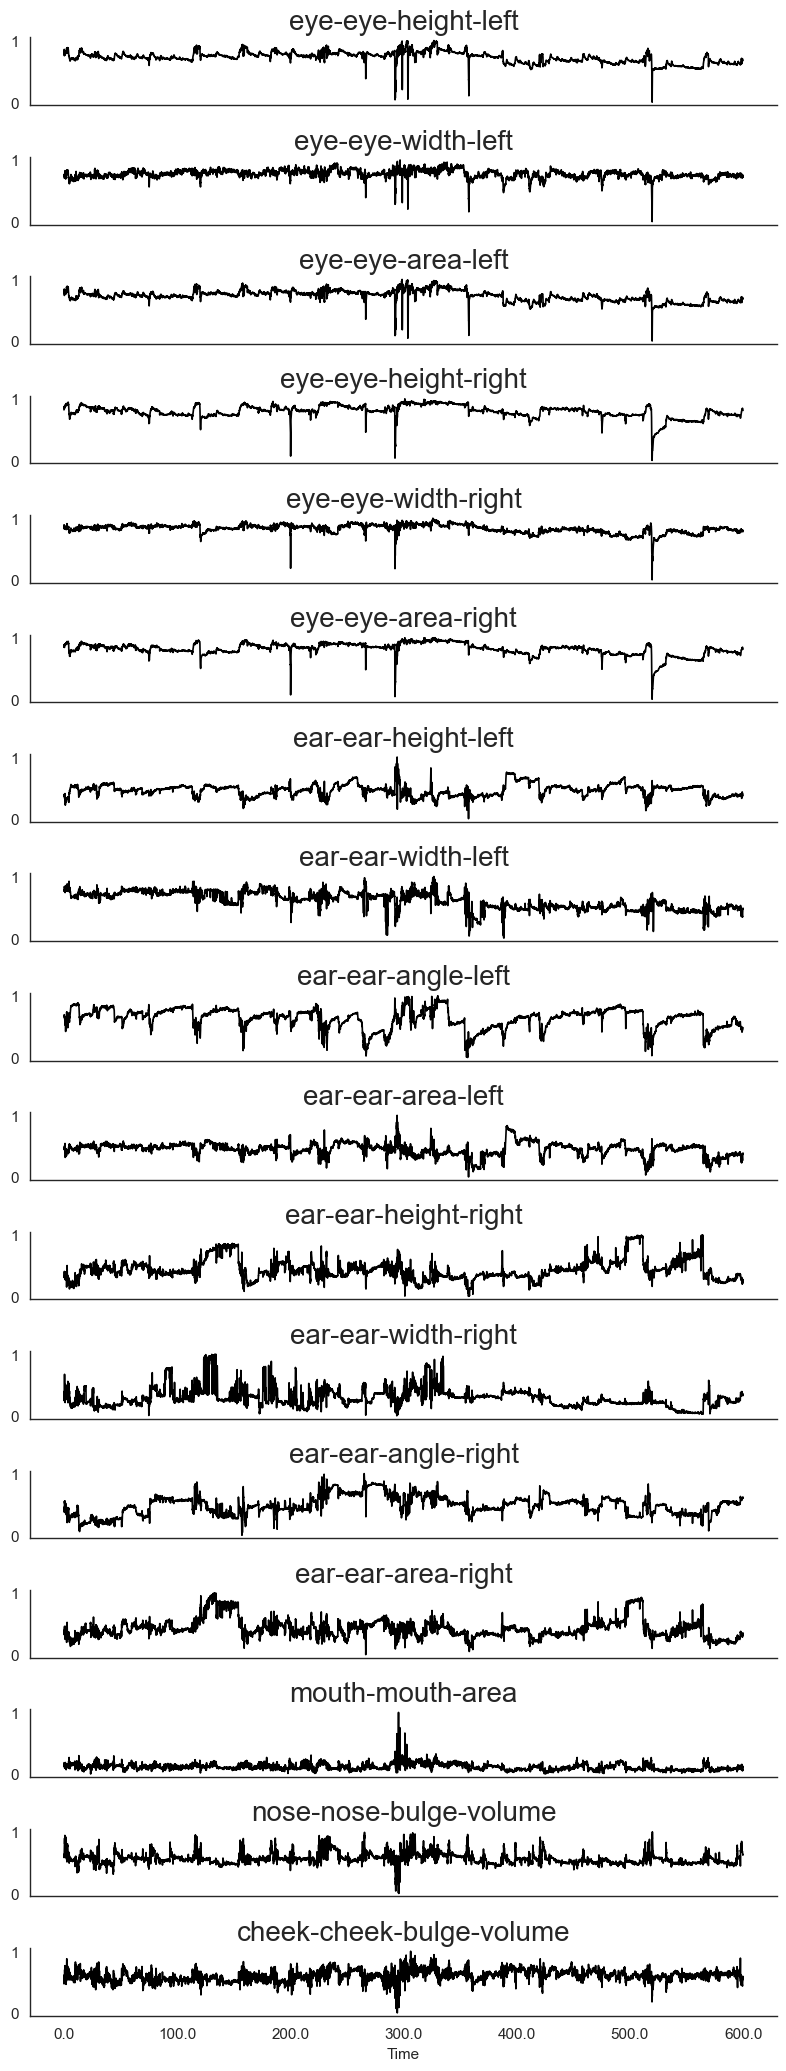

In [95]:
# Normalized facial movement
def plot_trace(data, color, label):
    sns.lineplot(x=np.arange(len(data)), y=data,
                 color=color,
                 label=label)

n_mea_df = (clean_mea_df - clean_mea_df.min()) / (clean_mea_df.max() - clean_mea_df.min())   
n_mea_df_melted = n_mea_df.melt(var_name='measurement', value_name='timeseries')
selected_n_mea_df_melted = pd.concat([n_mea_df.iloc[:,0:6], n_mea_df.iloc[:,7], n_mea_df.iloc[:,9], n_mea_df.iloc[:,11], n_mea_df.iloc[:,13]], axis=1).melt(var_name='measurement', value_name='timeseries')

g = sns.FacetGrid(n_mea_df_melted,
                  col="measurement", hue="measurement",
                  col_wrap=1, aspect=8, height=1,
                  margin_titles=False, sharey=False)

g.map(plot_trace, "timeseries", color = 'k')

g.set_xlabels("Time")
g.tick_params(left = False, bottom=False)
g.set_ylabels("")
g.set_titles(col_template="{col_name}")
g.tight_layout()
g.fig.subplots_adjust(top=1.2)

for ax in g.axes.flat:
    plt.plot(ax=ax, left=True, bottom=True)
    ax.tick_params(axis="both", which="both", bottom=False, left=False)
    ax.set_xticklabels(ax.get_xticks() / 100)
    ax.set_title(ax.get_title(), fontsize=20)

plt.show()

In [96]:
def convert_times_to_train(spike_times, start_time =0, end_time = 600, bin_size = 0.001): # 0.001 s
    num_bins = int((end_time - start_time)/bin_size)
    spike_train = np.zeros(num_bins, dtype = int)
    for spike_time in spike_times:
        if start_time <= spike_time < end_time:
            bin_index = int((spike_time - start_time)/bin_size)
            spike_train[bin_index] = 1
    return spike_train

def convert_train_to_times(spike_train, start_time = 0, bin_size = 0.001):
    spike_indices = np.where(spike_train == 1)[0]
    spike_times = spike_indices * bin_size + start_time
    return spike_times

def cyclic_shuffle_spikes(spike_times, interval=(-60, 60), exclude=(-15, 15), start_time=0, end_time=600, bin_size = 0.001):
    spike_train = convert_times_to_train(spike_times, start_time, end_time, bin_size)
    rng = np.random.default_rng()
    low_range = (int(interval[0] / bin_size), int(exclude[0] / bin_size))
    high_range = (int(exclude[1] / bin_size), int(interval[1] / bin_size))

    # Randomly select from the two ranges
    if rng.random() < 0.5:  # 50% probability
        shift = rng.integers(*low_range)
    else:
        shift = rng.integers(*high_range)

    shuffled_spike_train = np.roll(spike_train, shift)
    shuffled_spike_times = convert_train_to_times(shuffled_spike_train, start_time, bin_size)
    return shuffled_spike_times

Figure 5H. tuning curve (the "ear-angle-right" column for units 14 and 7)

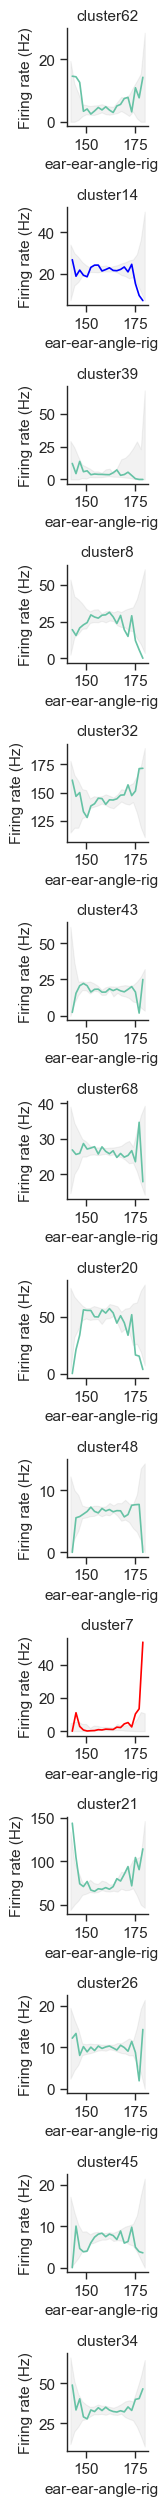

In [104]:
# Plot 1D tuning curve
start_time = 0
end_time = 600

facial_features_labels = ['ear-ear-angle-right']
fig, axes = plt.subplots(len(spike_file_names), 1, figsize=(12/7, 1.8*len(spike_file_names)))

axes = axes.flatten() 

n_permutations = 1000

for i, cluster_name in enumerate(spike_file_names):
    for j, facial_feature_label in enumerate(facial_features_labels):
        ax = axes[i * len(facial_features_labels) + j] 
        facial_features = clean_mea_df[facial_feature_label] 
        spike_times = spike_time[cluster_name] 
        spike_times = spike_times[(spike_times >= start_time) & (spike_times <= end_time)]   
        time_series = np.arange(start_time, end_time, 1/100)

        # Bin the facial feature measurements
        bin_edges = np.linspace(np.min(facial_features), np.max(facial_features), 21)  # n bin edges, n-1 bins
        bin_indices = np.digitize(facial_features, bin_edges) - 1 # which bin the facial data belongs to (np.digitize's output index starts from 1). Output: 0-(n-1)
        bin_indices = np.clip(bin_indices, 0, len(bin_edges) - 2) # bin index: 0-(n-2)

        # Compute the time interval in each bin
        time_diff = np.diff(time_series)  # Time intervals
        bin_time = np.bincount(bin_indices, weights=time_diff)

        # Count spikes in each bin; find the indice of each spike, and the bin (of y-axis) it falls into
        spike_bins = np.digitize(spike_times, time_series) # [8, 17, ..., 59978]
        spike_bins = np.clip(spike_bins, 1, len(bin_indices))
        spike_counts = np.bincount(bin_indices[spike_bins - 1], minlength=len(bin_edges) - 1) 
        
        firing_rate = spike_counts / bin_time
        firing_rate[np.isnan(firing_rate)] = 0  # Handle division by zero

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        if cluster_name in selected_spike_names_1:
            ax.plot(bin_centers, firing_rate, color = 'red')
        elif cluster_name in selected_spike_names_2:
            ax.plot(bin_centers, firing_rate, color = 'blue')
        else:
            ax.plot(bin_centers, firing_rate)

        # plot shuffled data - shuffle spike times
        all_firing_rate = []
        for k in range(n_permutations):
             shuffled_spike_times = cyclic_shuffle_spikes(spike_times)
             spike_bins = np.digitize(shuffled_spike_times, time_series) 
             spike_bins = np.clip(spike_bins, 1, len(bin_indices))
             spike_counts = np.bincount(bin_indices[spike_bins - 1], minlength=len(bin_edges) - 1) 
             firing_rate = spike_counts / bin_time
             firing_rate[np.isnan(firing_rate)] = 0  # Handle division by zero
             all_firing_rate.append(firing_rate)

        all_firing_rate = np.array(all_firing_rate)
        ci_lower = np.percentile(all_firing_rate, 2.5, axis=0)
        ci_upper = np.percentile(all_firing_rate, 97.5, axis=0)
        ax.fill_between(np.linspace(np.min(facial_features), np.max(facial_features),num=len(ci_lower)), ci_lower, ci_upper, color='gray', alpha=0.1, label='95% CI') 
       
        ax.set_xlabel(f"{facial_feature_label}")
        ax.set_ylabel("Firing rate (Hz)")
        ax.set_title(f"{cluster_name[:-4]}")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
# save_figure(OUTPUT_DIR, f"{SESSION_INDEX}_{cluster_name[:-4]}_tuning_curves", fig, formats=["svg","png"])
# save_figure(OUTPUT_DIR, f"{SESSION_INDEX}_tuning_curves", fig, formats=["svg","png"])
plt.show()

In [99]:
# Normalized firing rate
n_fr = {}

for unit, firing_rates in fr.items():
    min_rate = np.min(firing_rates)
    max_rate = np.max(firing_rates)
    # Normalize to [0, 1]
    n_fr[unit] = (firing_rates - min_rate) / (max_rate - min_rate)

<Figure size 800x1200 with 0 Axes>

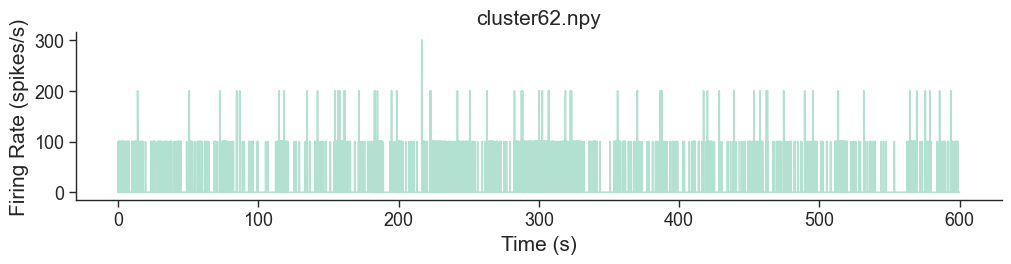

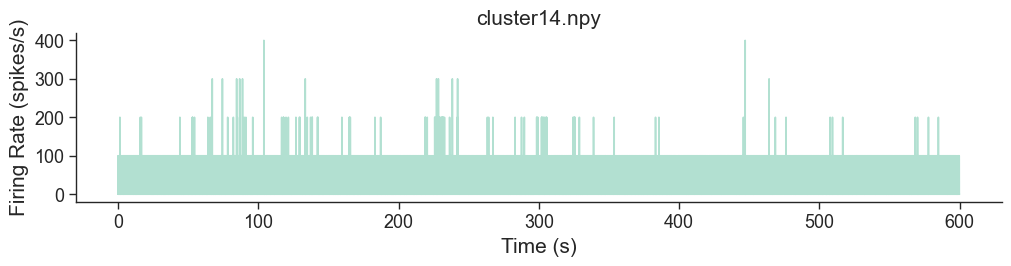

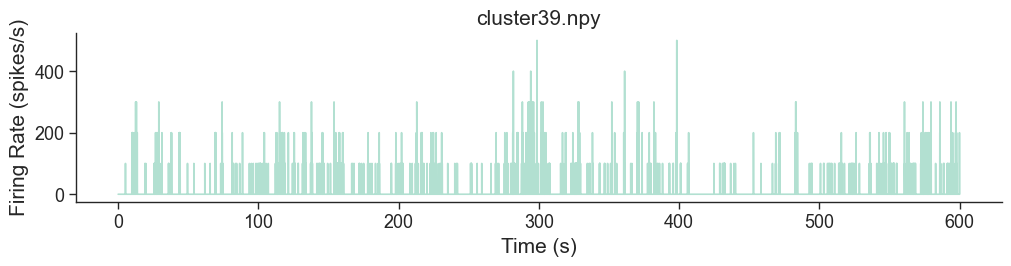

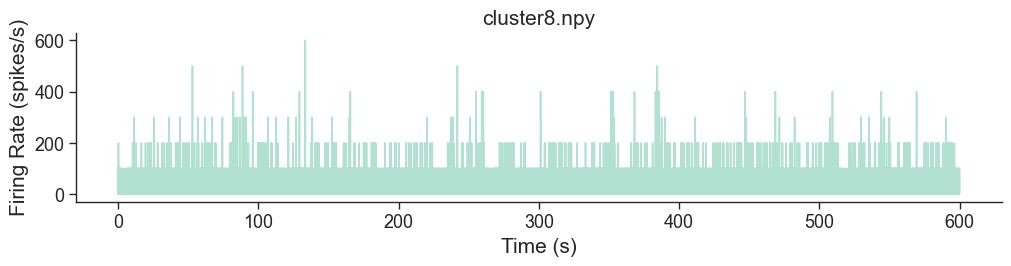

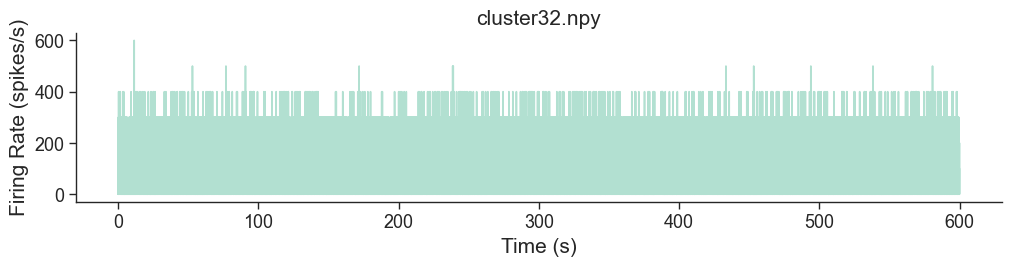

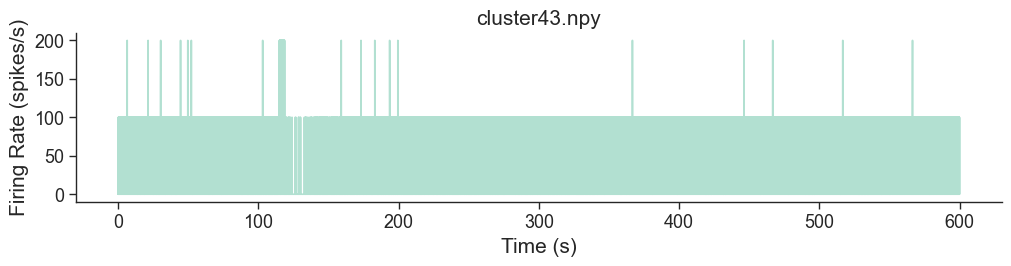

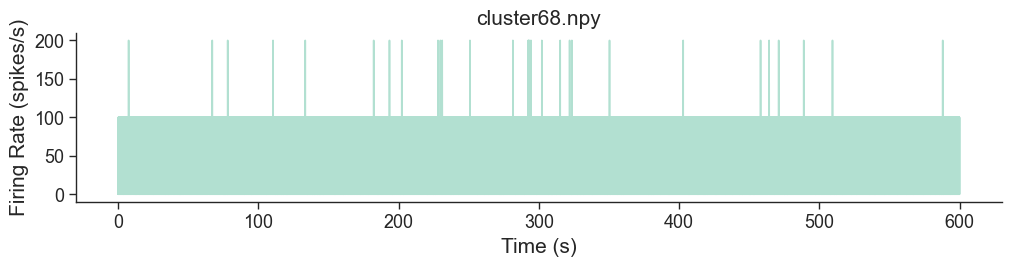

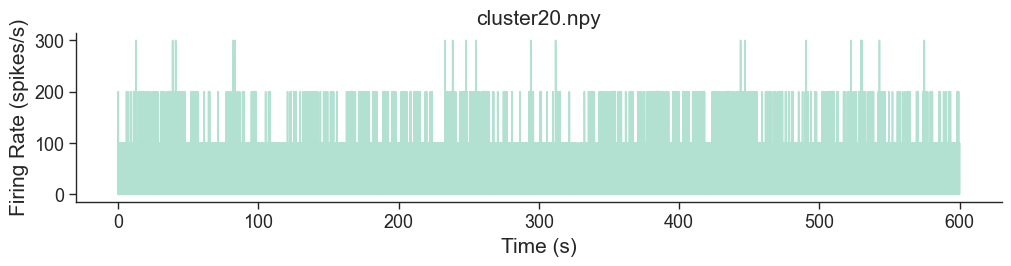

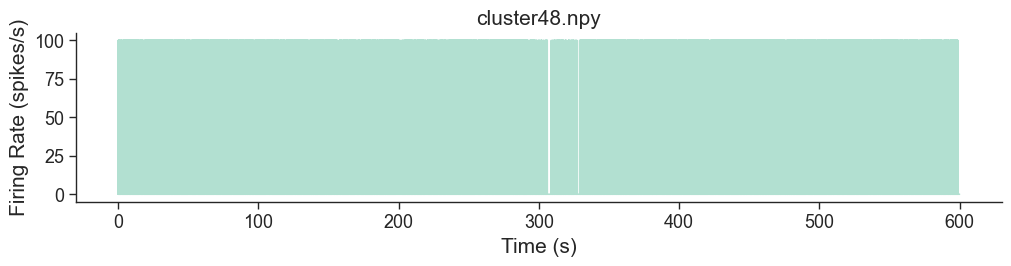

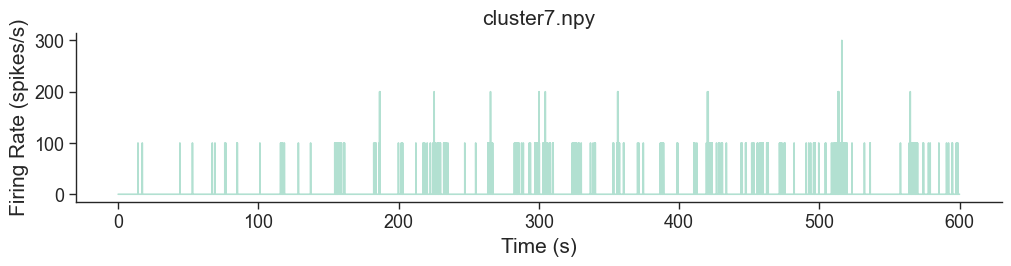

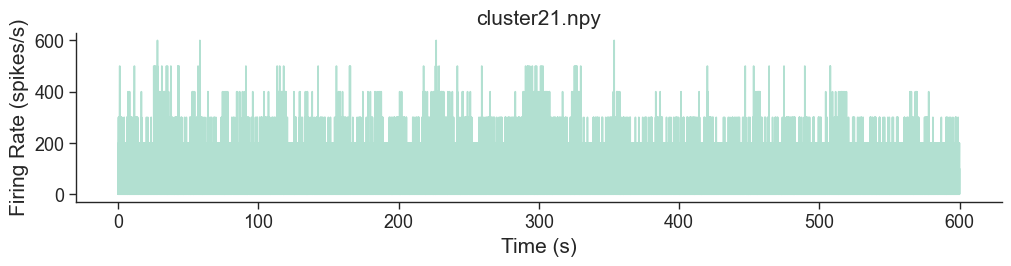

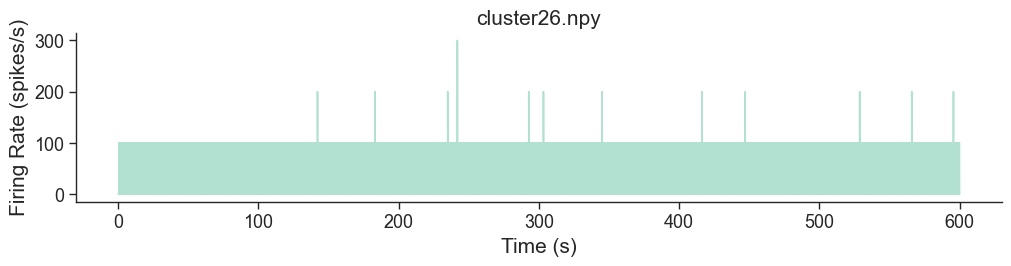

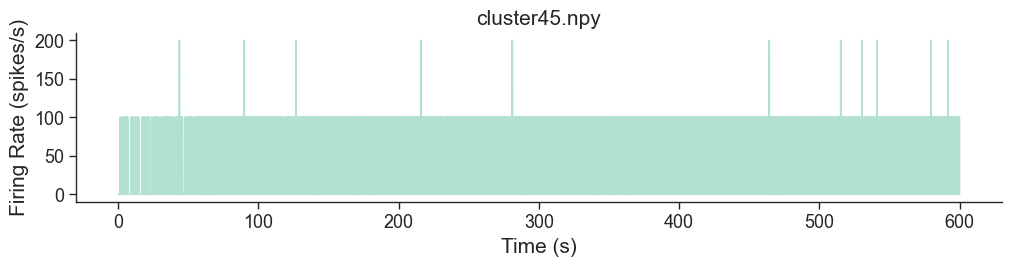

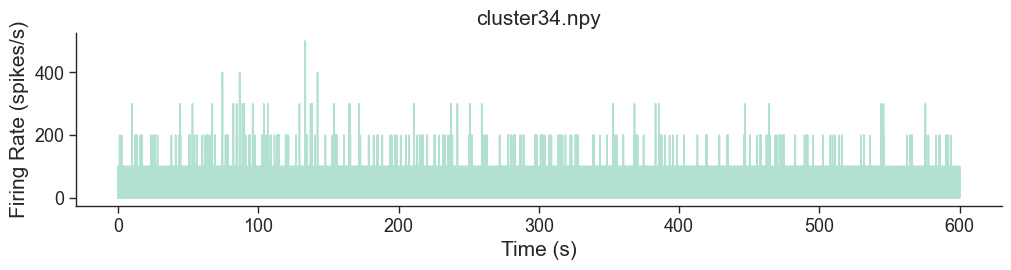

In [100]:
plt.figure(figsize=(8, 12))
counter = 1
# for cluster_id, firing_rates in selected_fr.items():
#     ax = plt.subplot(len(selected_fr), 1, counter)
for cluster_id, firing_rates in fr.items():
    plt.figure(figsize=[10,30])
    ax = plt.subplot(len(fr), 1, counter)
    plt.plot(np.arange(0, len(firing_rates[0]) * time_window, time_window), firing_rates[0], label=f'Cluster {cluster_id}', alpha=0.5)
    counter = counter + 1 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f'{cluster_id}',fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Firing Rate (spikes/s)', fontsize=15)

# ylabel = plt.ylabel('Firing Rate (spikes/s)', fontsize=25)
# ylabel.set_y(25)
plt.show()

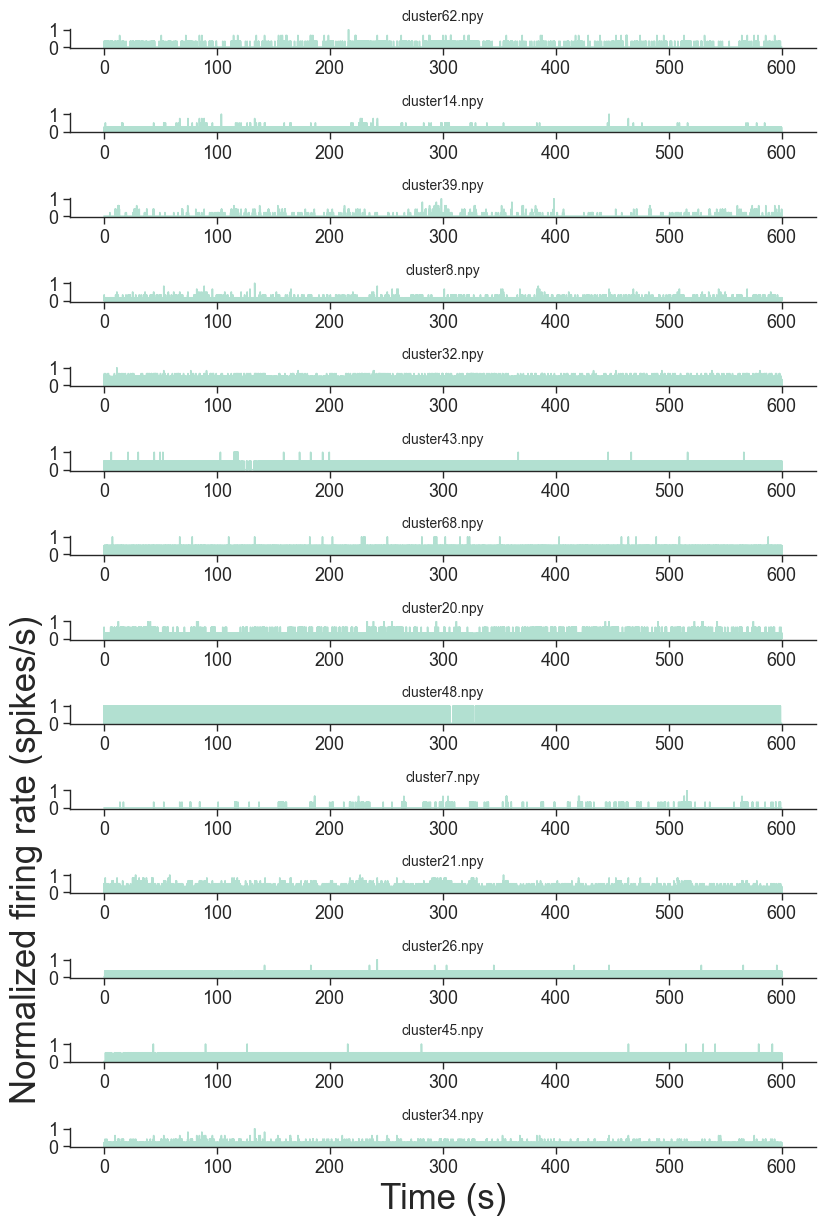

In [101]:
# Normalize firing rate
plt.figure(figsize=(8, 12))
counter = 1
# for cluster_id, firing_rates in selected_fr.items():
#     ax = plt.subplot(len(selected_fr), 1, counter)
for cluster_id, firing_rates in n_fr.items():
    ax = plt.subplot(len(n_fr), 1, counter)
    plt.plot(np.arange(0, len(firing_rates[0]) * time_window, time_window), firing_rates[0], label=f'Cluster {cluster_id}', alpha=0.5)
    counter = counter + 1 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f'{cluster_id}',fontsize=10)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
plt.xlabel('Time (s)', fontsize=25)
ylabel = plt.ylabel('Normalized firing rate (spikes/s)', fontsize=25)
ylabel.set_y(15)
plt.show()

Figure 5H. correlation plots for units 14 and 7

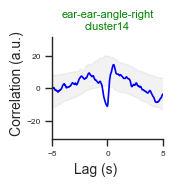

In [102]:
# Cross-correlation between shuffled ephys and facial movements (all units in one session)
start_time = 0
end_time = 600
count_unit = 0 # count of units
count_facial_feature = 0 # count of facial features

slices = [(12, 13)]
selected_items = chain.from_iterable(islice(n_mea_df.items(), start, end) for start, end in slices)

# shuffle 1000 times
n_permutations = 1000
n_units = 1
p_values = np.ones((n_units, 17))
fig, axes = plt.subplots(nrows=n_units, ncols=1, figsize = (12/7*1,1.8))
axes = np.atleast_2d(axes)

for cluster_number, _ in islice(n_fr.items(),1,2):
    spike_times = spike_time[cluster_number]
    for facial_feature, facial_data in selected_items: 
        facial_data = facial_data.astype(np.float32)
        shuffled_correlations = []
        count_figure = count_unit*17 + count_facial_feature + 1
        
        for j in range(n_permutations):
            # cyclic shuffle spike times; calculate normalized firing rate for shuffled spike data
            shuffled_spike_times_dict = {}
            shuffled_spike_times = cyclic_shuffle_spikes(spike_times)
            shuffled_spike_times_dict[cluster_number] = shuffled_spike_times
            shuffled_fr = calculate_firing_rate(shuffled_spike_times_dict, time_window, start_time, end_time)
            shuffled_n_fr = (shuffled_fr[cluster_number] - np.min(shuffled_fr[cluster_number]))/(np.max(shuffled_fr[cluster_number]) - np.min(shuffled_fr[cluster_number]))
            correlation = signal.correlate(shuffled_n_fr[0], facial_data, mode='full')
            lag = signal.correlation_lags(len(shuffled_n_fr[0]), len(facial_data))/100 # s
            
            correlation = np.array(correlation, dtype=np.float32) # downcast to free memory
            lag = np.array(lag, dtype=np.float32)
            bkg_correlation = np.concatenate((np.array(correlation[int(len(correlation)/2-500):int(len(correlation)/2-200)]), np.array(correlation[int(len(correlation)/2+200):int(len(correlation)/2+500)]))).astype(np.float32)
            mean_bkg_correlation = np.mean(bkg_correlation)
            shuffled_correlations.append(correlation - mean_bkg_correlation)

        # Compute confidence intervals (0.05th and 99.95th percentiles for p < 0.001)
        shuffled_correlations = np.array(shuffled_correlations)
        ci_lower = np.percentile(shuffled_correlations, 0.05, axis=0)
        ci_upper = np.percentile(shuffled_correlations, 99.95, axis=0)

        # plt.subplot(1,17,count_facial_feature+1) 
        ax = axes[count_unit, count_facial_feature] 
        ax.fill_between(lag, ci_lower, ci_upper, color='gray', alpha=0.1, label='99.9% CI') 
        # plt.plot(lag, correlation - mean_bkg_correlation, label= facial_feature, color = 'gray', alpha = 0.5)

        # plot original data (not shuffled) 
        original_correlation = signal.correlate(n_fr[cluster_number][0], facial_data, mode='full')
        original_lag = signal.correlation_lags(len(facial_data), len(n_fr[cluster_number][0]))/100 # s
        original_correlation = np.array(original_correlation, dtype=np.float32)
        original_lag = np.array(original_lag, dtype=np.float32)
        original_bkg_correlation = np.concatenate((np.array(original_correlation[int(len(original_correlation)/2-500):int(len(original_correlation)/2-200)]), np.array(original_correlation[int(len(original_correlation)/2+200):int(len(original_correlation)/2+500)]))).astype(np.float32)
        original_mean_bkg_correlation = np.mean(original_bkg_correlation)

        original_around_lag_0_correlation = np.array(original_correlation[int(len(original_correlation)/2-50):int(len(original_correlation)/2+50)]) # -0.5 ~ 0.5 s
        original_mean_around_lag_0_correlation = np.mean(original_around_lag_0_correlation)

        if original_mean_around_lag_0_correlation <= original_mean_bkg_correlation: # a trough in the correlation trace
            peak_index = np.argmin(original_around_lag_0_correlation)
        else: # a peak in the correlation trace
            peak_index = np.argmax(original_around_lag_0_correlation)

        original_peak_correlation = original_correlation[int(len(original_correlation)/2-50)+peak_index] - original_mean_bkg_correlation
        original_corresponding_lag = original_lag[int(len(original_lag)/2-50)+peak_index]
        ax.set_title(f'{facial_feature}\n{cluster_number[:-4]}', fontsize=8, color = 'black')
        if original_peak_correlation > ci_upper[int(len(original_correlation)/2-50)+peak_index] or original_peak_correlation < ci_lower[int(len(original_correlation)/2-50)+peak_index]:
            if original_corresponding_lag <= 0 and original_corresponding_lag >= -0.1: # spike precedes facial movement by time within 100 ms
                p_values[count_unit, count_facial_feature] = 0
                ax.set_title(f'{facial_feature}\n{cluster_number[:-4]}', fontsize=8, color = 'green')

        ax.plot(original_lag, original_correlation - original_mean_bkg_correlation, label = facial_feature, color = "blue")
        ylim = np.abs(original_correlation[int(len(original_correlation)/2-50)+peak_index] - original_mean_bkg_correlation)
        ax.set_xlim([-5,5])
        ax.set_ylim([-ylim-20,ylim+20])
        ax.set_xticks([-5, 0, 5])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=6)
        count_facial_feature += 1    
    count_unit += 1
    count_facial_feature = 0 
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.tight_layout()  
# fig.text(0, 0.5, 'Peak within 100 ms \n Correlation (a.u.)', va='center', rotation='vertical', fontsize=10)
fig.text(0, 0.5, 'Correlation (a.u.)', va='center', rotation='vertical', fontsize=10)
fig.text(0.5, 0, 'Lag (s)', ha='center', fontsize=10)
fig.align_ylabels(axes[:, 0])
# save_figure(OUTPUT_DIR, f"{SESSION_INDEX}_{cluster_number[:-4]}_corr_mouth_cyclic_100ms", fig, formats=["svg","png"])

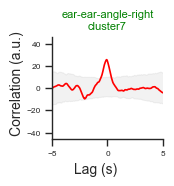

In [103]:
# Cross-correlation between shuffled ephys and facial movements (all units in one session)
start_time = 0
end_time = 600
count_unit = 0 # count of units
count_facial_feature = 0 # count of facial features

slices = [(12, 13)]
selected_items = chain.from_iterable(islice(n_mea_df.items(), start, end) for start, end in slices)

# shuffle 1000 times
n_permutations = 1000
n_units = 1
p_values = np.ones((n_units, 17))
fig, axes = plt.subplots(nrows=n_units, ncols=1, figsize = (12/7*1,1.8))
axes = np.atleast_2d(axes)

for cluster_number, _ in islice(n_fr.items(),9,10):
    spike_times = spike_time[cluster_number]
    for facial_feature, facial_data in selected_items: 
        facial_data = facial_data.astype(np.float32)
        shuffled_correlations = []
        count_figure = count_unit*17 + count_facial_feature + 1
        
        for j in range(n_permutations):
            # cyclic shuffle spike times; calculate normalized firing rate for shuffled spike data
            shuffled_spike_times_dict = {}
            shuffled_spike_times = cyclic_shuffle_spikes(spike_times)
            shuffled_spike_times_dict[cluster_number] = shuffled_spike_times
            shuffled_fr = calculate_firing_rate(shuffled_spike_times_dict, time_window, start_time, end_time)
            shuffled_n_fr = (shuffled_fr[cluster_number] - np.min(shuffled_fr[cluster_number]))/(np.max(shuffled_fr[cluster_number]) - np.min(shuffled_fr[cluster_number]))
            correlation = signal.correlate(shuffled_n_fr[0], facial_data, mode='full')
            lag = signal.correlation_lags(len(shuffled_n_fr[0]), len(facial_data))/100 # s
            
            correlation = np.array(correlation, dtype=np.float32) # downcast to free memory
            lag = np.array(lag, dtype=np.float32)
            bkg_correlation = np.concatenate((np.array(correlation[int(len(correlation)/2-500):int(len(correlation)/2-200)]), np.array(correlation[int(len(correlation)/2+200):int(len(correlation)/2+500)]))).astype(np.float32)
            mean_bkg_correlation = np.mean(bkg_correlation)
            shuffled_correlations.append(correlation - mean_bkg_correlation)

        # Compute confidence intervals (0.05th and 99.95th percentiles for p < 0.001)
        shuffled_correlations = np.array(shuffled_correlations)
        ci_lower = np.percentile(shuffled_correlations, 0.05, axis=0)
        ci_upper = np.percentile(shuffled_correlations, 99.95, axis=0)

        # plt.subplot(1,17,count_facial_feature+1) 
        ax = axes[count_unit, count_facial_feature] 
        ax.fill_between(lag, ci_lower, ci_upper, color='gray', alpha=0.1, label='99.9% CI') 
        # plt.plot(lag, correlation - mean_bkg_correlation, label= facial_feature, color = 'gray', alpha = 0.5)

        # plot original data (not shuffled) 
        original_correlation = signal.correlate(n_fr[cluster_number][0], facial_data, mode='full')
        original_lag = signal.correlation_lags(len(facial_data), len(n_fr[cluster_number][0]))/100 # s
        original_correlation = np.array(original_correlation, dtype=np.float32)
        original_lag = np.array(original_lag, dtype=np.float32)
        original_bkg_correlation = np.concatenate((np.array(original_correlation[int(len(original_correlation)/2-500):int(len(original_correlation)/2-200)]), np.array(original_correlation[int(len(original_correlation)/2+200):int(len(original_correlation)/2+500)]))).astype(np.float32)
        original_mean_bkg_correlation = np.mean(original_bkg_correlation)

        original_around_lag_0_correlation = np.array(original_correlation[int(len(original_correlation)/2-50):int(len(original_correlation)/2+50)]) # -0.5 ~ 0.5 s
        original_mean_around_lag_0_correlation = np.mean(original_around_lag_0_correlation)

        if original_mean_around_lag_0_correlation <= original_mean_bkg_correlation: # a trough in the correlation trace
            peak_index = np.argmin(original_around_lag_0_correlation)
        else: # a peak in the correlation trace
            peak_index = np.argmax(original_around_lag_0_correlation)

        original_peak_correlation = original_correlation[int(len(original_correlation)/2-50)+peak_index] - original_mean_bkg_correlation
        original_corresponding_lag = original_lag[int(len(original_lag)/2-50)+peak_index]
        ax.set_title(f'{facial_feature}\n{cluster_number[:-4]}', fontsize=8, color = 'black')
        if original_peak_correlation > ci_upper[int(len(original_correlation)/2-50)+peak_index] or original_peak_correlation < ci_lower[int(len(original_correlation)/2-50)+peak_index]:
            if original_corresponding_lag <= 0 and original_corresponding_lag >= -0.1: # spike precedes facial movement by time within 100 ms
                p_values[count_unit, count_facial_feature] = 0
                ax.set_title(f'{facial_feature}\n{cluster_number[:-4]}', fontsize=8, color = 'green')

        ax.plot(original_lag, original_correlation - original_mean_bkg_correlation, label = facial_feature, color = "red")
        ylim = np.abs(original_correlation[int(len(original_correlation)/2-50)+peak_index] - original_mean_bkg_correlation)
        ax.set_xlim([-5,5])
        ax.set_ylim([-ylim-20,ylim+20])
        ax.set_xticks([-5, 0, 5])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=6)
        count_facial_feature += 1    
    count_unit += 1
    count_facial_feature = 0 
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.tight_layout()  
# fig.text(0, 0.5, 'Peak within 100 ms \n Correlation (a.u.)', va='center', rotation='vertical', fontsize=10)
fig.text(0, 0.5, 'Correlation (a.u.)', va='center', rotation='vertical', fontsize=10)
fig.text(0.5, 0, 'Lag (s)', ha='center', fontsize=10)
fig.align_ylabels(axes[:, 0])
# save_figure(OUTPUT_DIR, f"{SESSION_INDEX}_{cluster_number[:-4]}_corr_mouth_cyclic_100ms", fig, formats=["svg","png"])